#### Import necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import geopy
from geopy.geocoders import Nominatim
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMapWithTime
from collections import defaultdict, OrderedDict

##### Load the dataset in space_df dataframe

In [2]:
space_df= pd.read_csv('../input/all-space-missions-from-1957/Space_Corrected.csv')
space_df.head()

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


##### studying the property of dataframe in general

In [3]:
#### getting the information about dataset
space_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      4324 non-null   int64 
 1   Unnamed: 0.1    4324 non-null   int64 
 2   Company Name    4324 non-null   object
 3   Location        4324 non-null   object
 4   Datum           4324 non-null   object
 5   Detail          4324 non-null   object
 6   Status Rocket   4324 non-null   object
 7    Rocket         964 non-null    object
 8   Status Mission  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


##### observations

1. Rocket feature has only 964 non null values out of 4324 values

2. there are features with integer and object datatype 

#### Dataset cleaning and Engineering 

In [4]:
#### Dropping the columns Unamed: 0 and Unnamed: 0.1 columns as they are of no use.
space_df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
space_df.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [5]:
#### rename columns to get the idea what each features does

space_df.columns=['Company Name','Location of Launch','Date of Launch','Rocket Name','Rocket Status','Mission Cost','Mission Status']
space_df.head()

,Company Name,Location of Launch,Date of Launch,Rocket Name,Rocket Status,Mission Cost,Mission Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [6]:
#### remove the duplicates values from the dataset
space_df.drop_duplicates(inplace=True)
space_df.shape

(4323, 7)

In [7]:
#### taking the missing values count of each feature
space_df.isnull().sum()

Company Name             0
Location of Launch       0
Date of Launch           0
Rocket Name              0
Rocket Status            0
Mission Cost          3360
Mission Status           0
dtype: int64

In [8]:
### since from result, Mission Cost has higer missing values (>50%), so it is better to drop that/ or keep a company for later reference
space_df_missioncost= space_df.copy()
space_df.drop('Mission Cost',inplace=True,axis=1)
space_df

,Company Name,Location of Launch,Date of Launch,Rocket Name,Rocket Status,Mission Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,Success
...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,Failure
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,Success
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,Failure
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,Success


In [9]:
#### Date Enginnering: Extract Month,Day,Year,Day Part from date
space_df['Date of Launch']= pd.to_datetime(space_df['Date of Launch'],utc=True)
space_df['Month of Launch']= space_df['Date of Launch'].dt.strftime('%b')
space_df['Year of Launch']= space_df['Date of Launch'].dt.year
space_df['Hour of Launch']= space_df['Date of Launch'].dt.hour
space_df['Day Part of Launch']= pd.cut(space_df['Hour of Launch'],bins=[-1,4,11,16,20,23],labels=['Night','Morning','Afternoon','Evening','Night'],ordered=False)
space_df.drop(['Hour of Launch'],axis=1,inplace=True)
space_df.head()



,Company Name,Location of Launch,Date of Launch,Rocket Name,Rocket Status,Mission Status,Month of Launch,Year of Launch,Day Part of Launch
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,Success,Aug,2020,Morning
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,Success,Aug,2020,Night
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,Success,Aug,2020,Night
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,Success,Jul,2020,Night
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,Success,Jul,2020,Morning


In [10]:
#### CHECKING Null values (confirming before moving to next step)

space_df.isnull().sum()

Company Name          0
Location of Launch    0
Date of Launch        0
Rocket Name           0
Rocket Status         0
Mission Status        0
Month of Launch       0
Year of Launch        0
Day Part of Launch    0
dtype: int64

In [11]:
#### extract country names/major place names & finally the longitudes , latitude from the location of launch
### getting the country names by spiltting the location of launch
space_df['Country/Main Place of Launch']= space_df['Location of Launch'].apply(lambda x: x.split(',')[-1])
space_df.head()

,Company Name,Location of Launch,Date of Launch,Rocket Name,Rocket Status,Mission Status,Month of Launch,Year of Launch,Day Part of Launch,Country/Main Place of Launch
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,Success,Aug,2020,Morning,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,Success,Aug,2020,Night,China
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,Success,Aug,2020,Night,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,Success,Jul,2020,Night,Kazakhstan
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,Success,Jul,2020,Morning,USA


In [12]:
## writing a function code to get the longitude & latitude of the Country [ for plotting the country in map] , will use the function later
def get_latitude_longitude(country):
    try:
        nm= Nominatim(user_agent='app')
        loc= nm.geocode(country)
        return loc.latitude,loc.longitude
    except:
        return np.nan,np.nan  

        
    

#### Data Analysis

In [13]:
space_df.head()

,Company Name,Location of Launch,Date of Launch,Rocket Name,Rocket Status,Mission Status,Month of Launch,Year of Launch,Day Part of Launch,Country/Main Place of Launch
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,Success,Aug,2020,Morning,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,Success,Aug,2020,Night,China
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,Success,Aug,2020,Night,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,Success,Jul,2020,Night,Kazakhstan
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,Success,Jul,2020,Morning,USA


<AxesSubplot:ylabel='Company Name'>

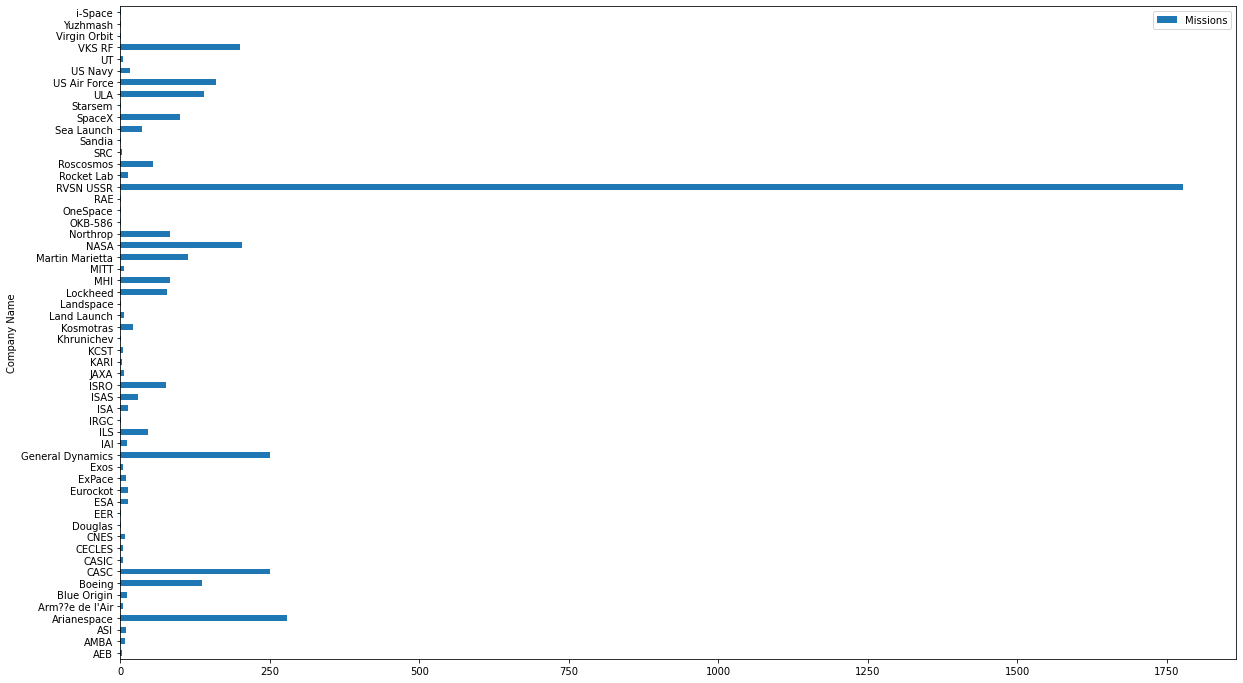

In [14]:
#### studying how much missions each company had done (including failed as well)
pd.DataFrame(space_df.groupby('Company Name').size(),columns=['Missions']).plot(kind='barh',figsize=(20,12))

Observations

1. RVSN USSR has conducted most space missions

2. Next comes NASA,VKS RF,ISRO, SPACEx, US Air force, General Dynamics, CASC, Arianespace etc

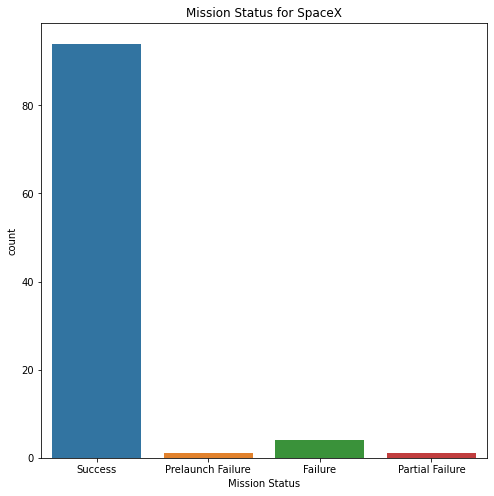

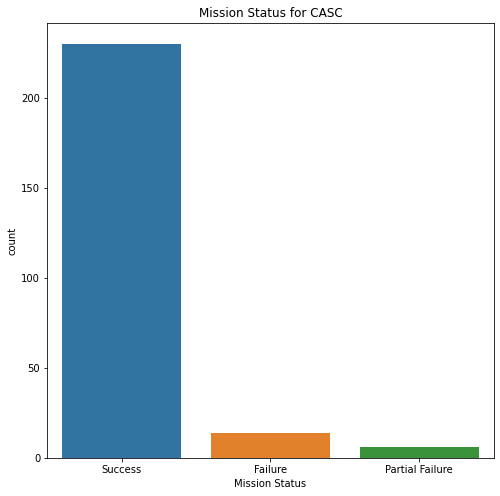

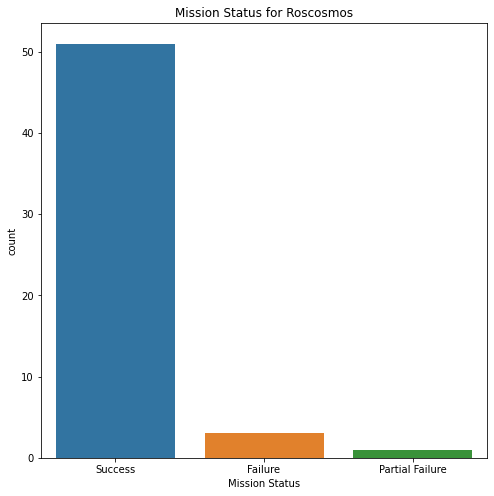

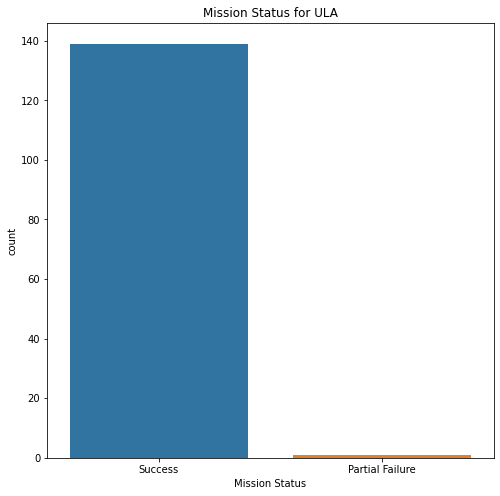

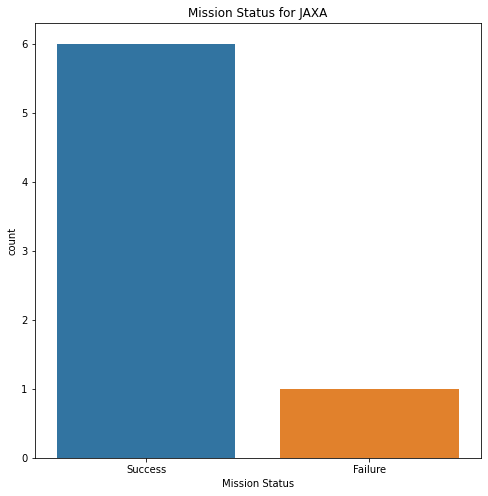

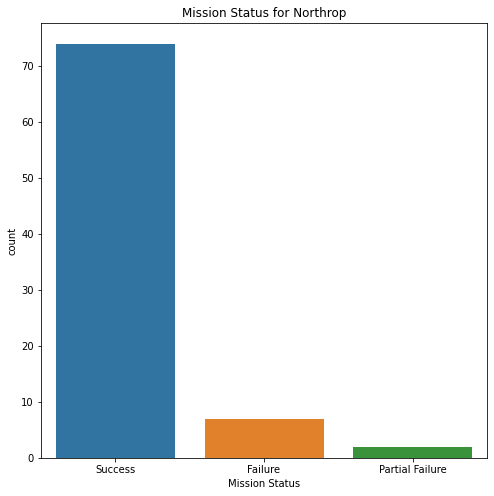

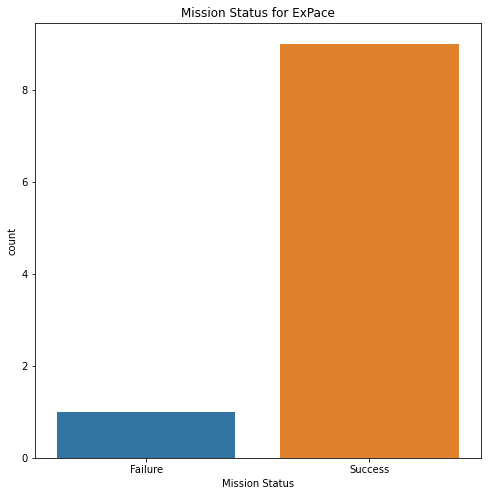

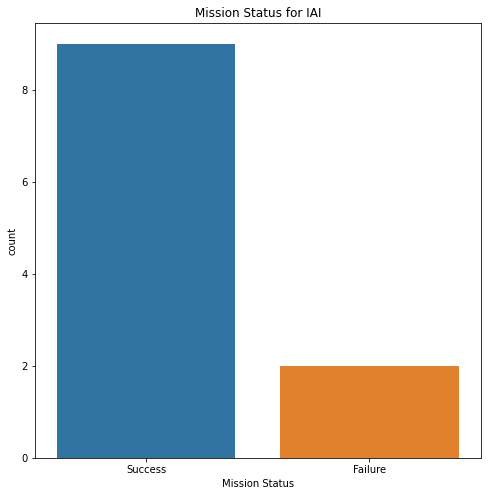

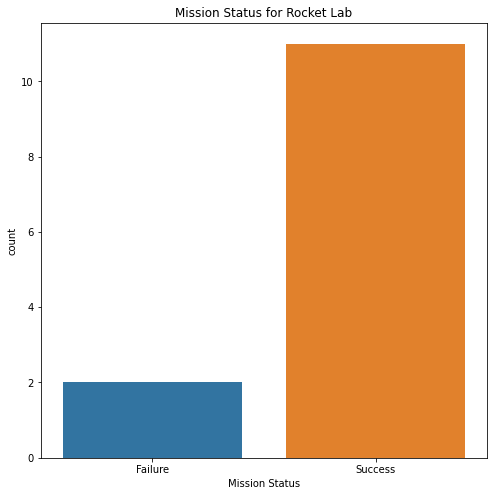

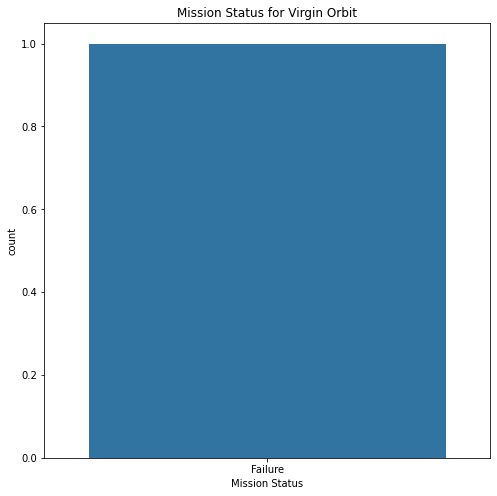

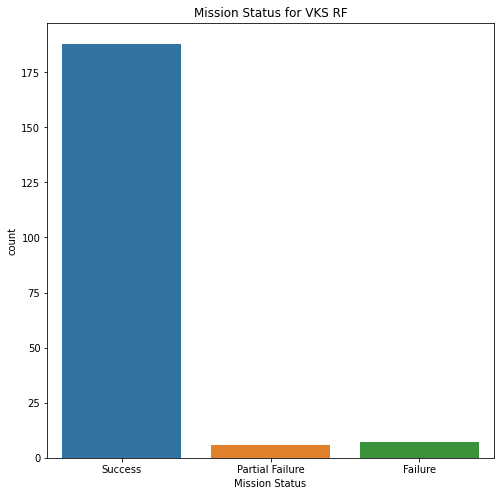

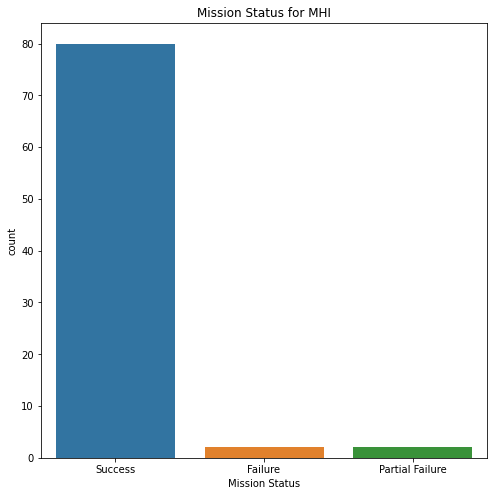

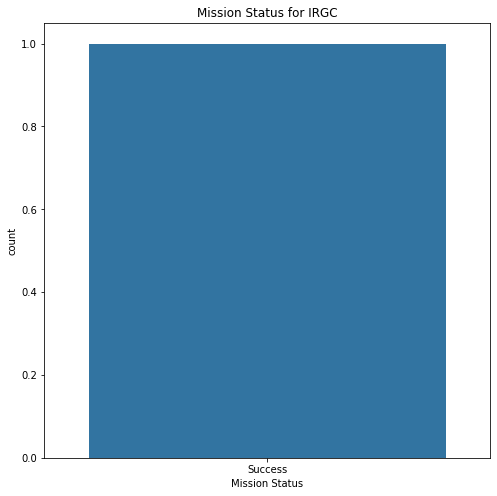

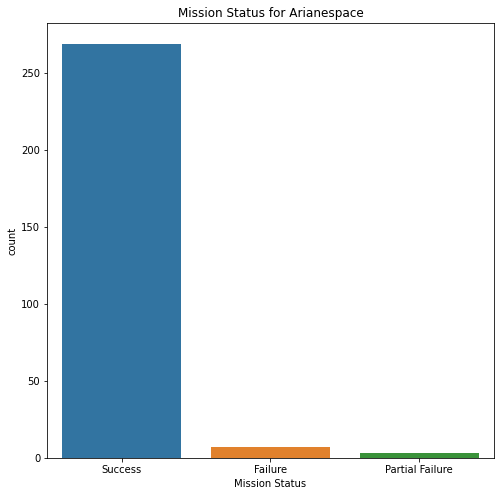

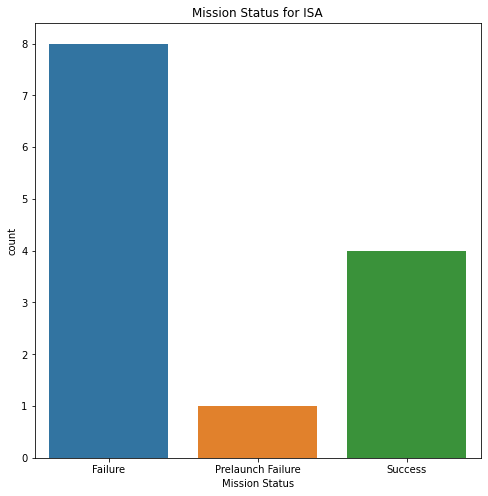

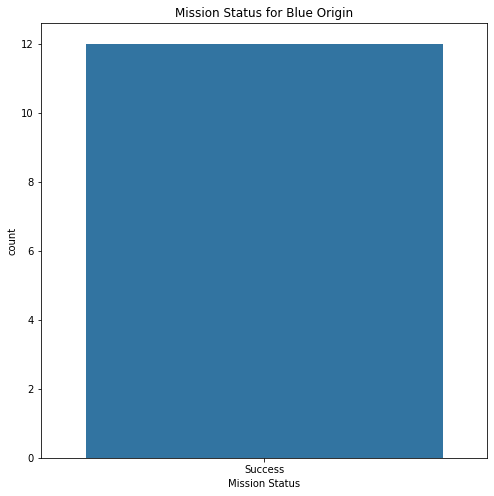

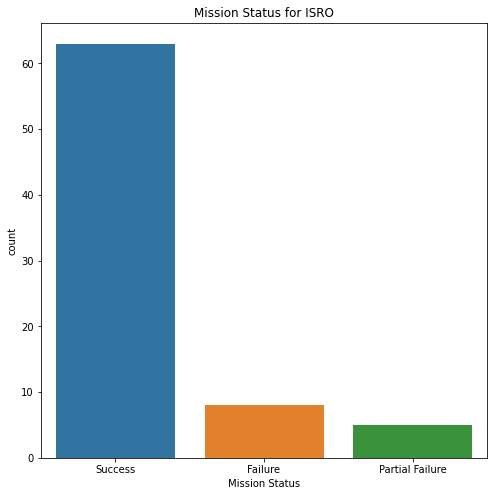

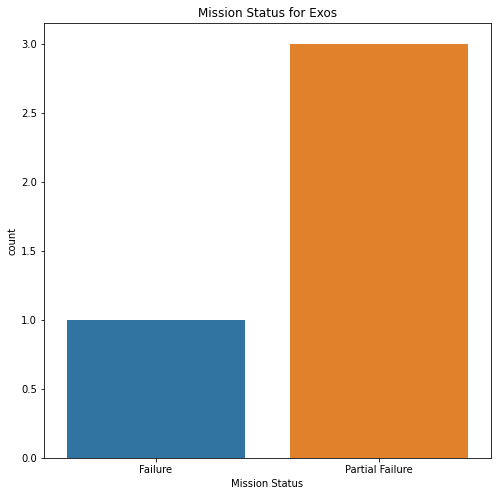

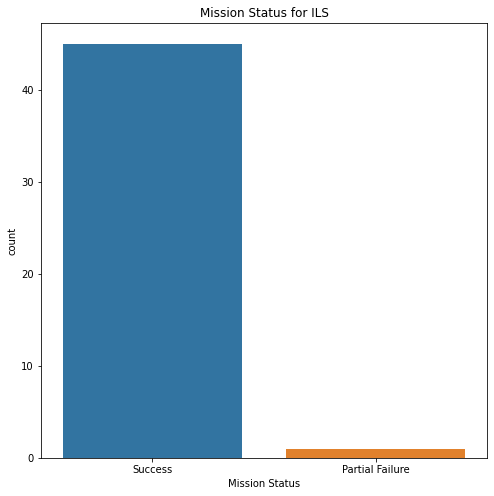

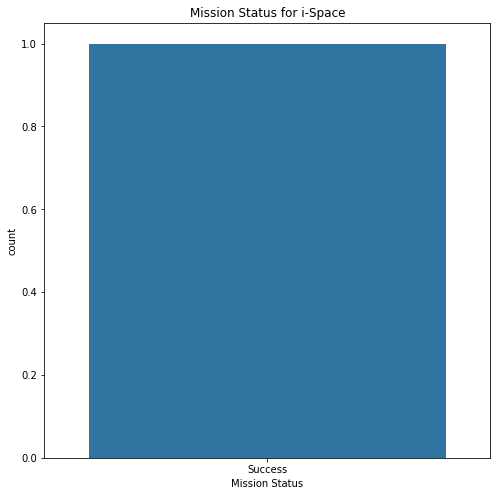

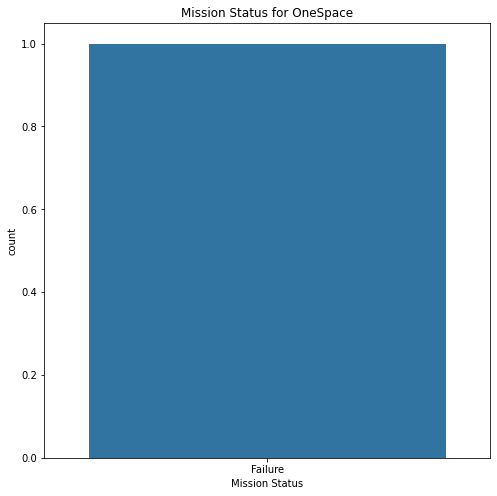

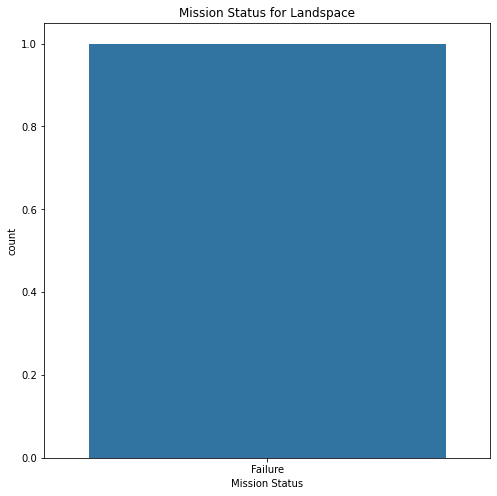

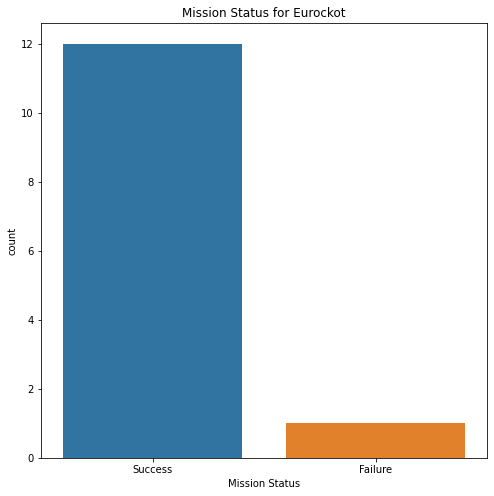

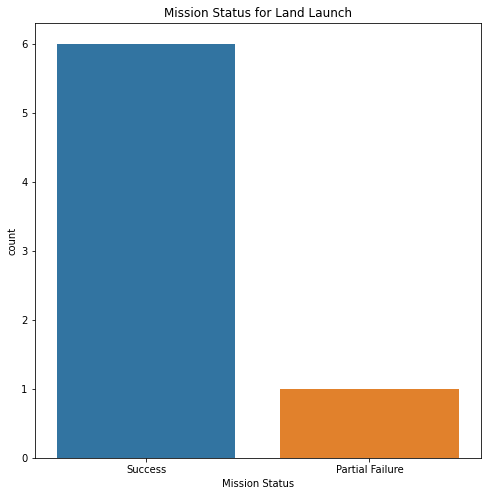

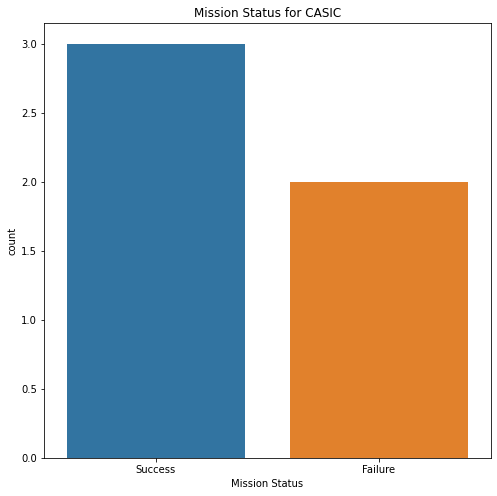

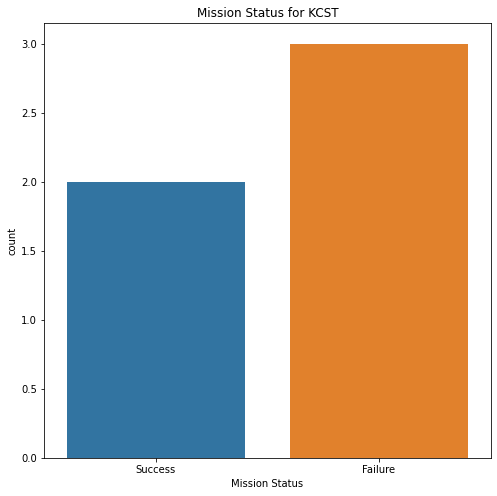

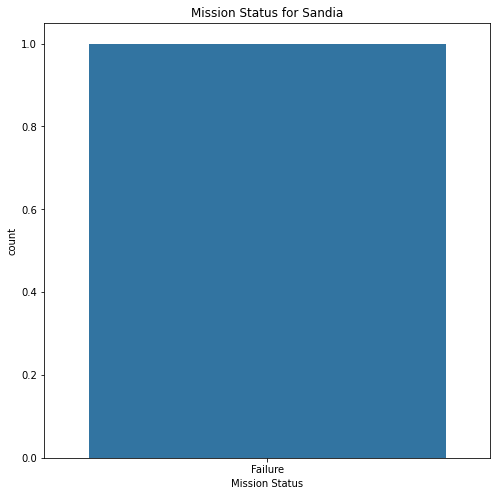

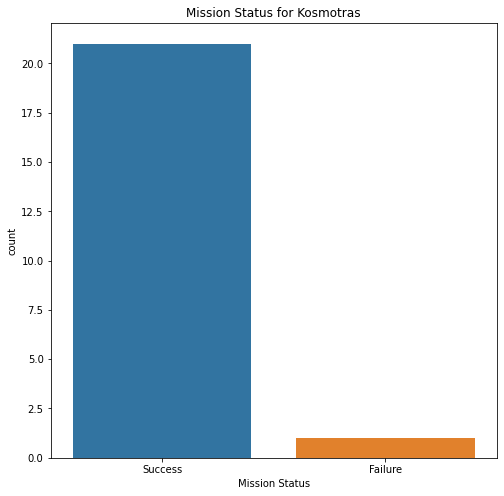

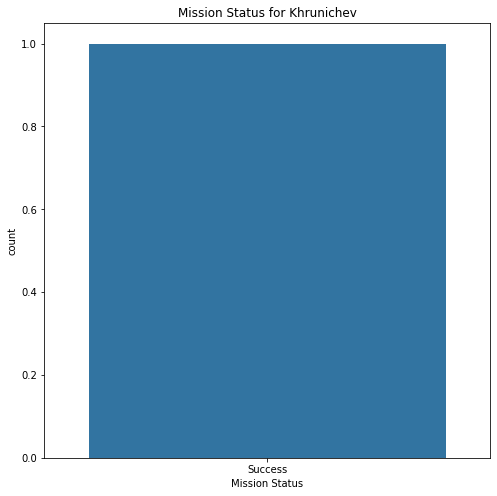

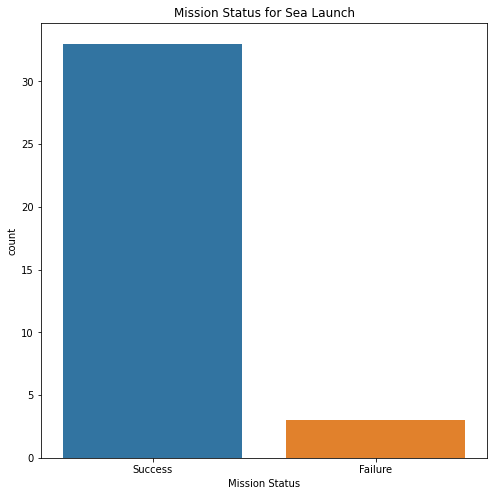

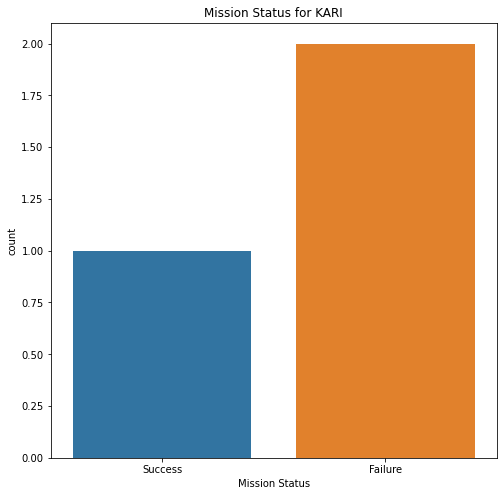

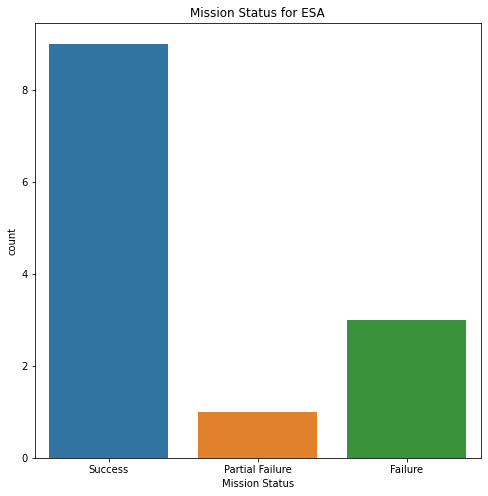

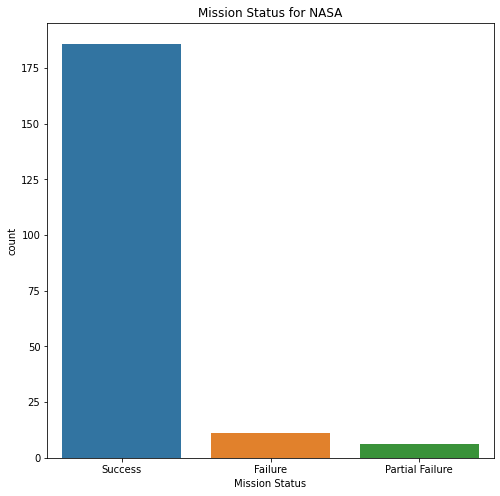

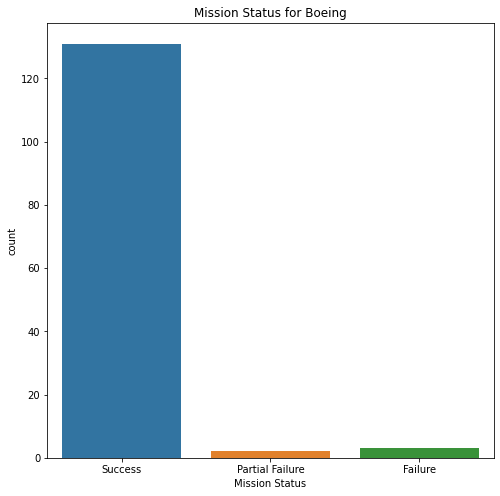

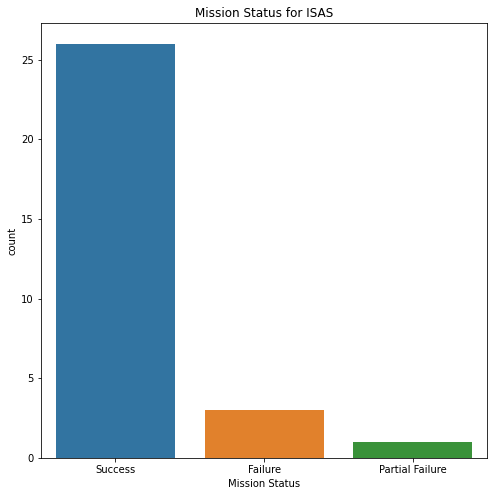

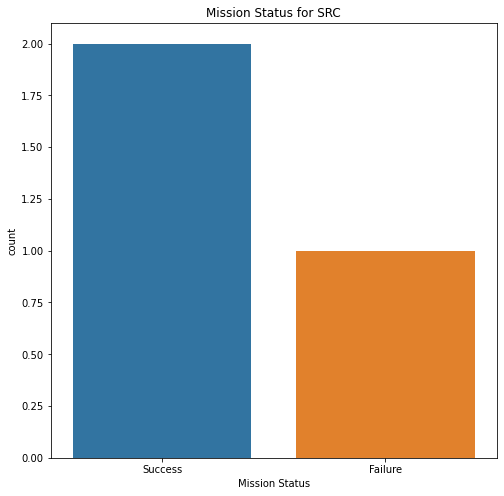

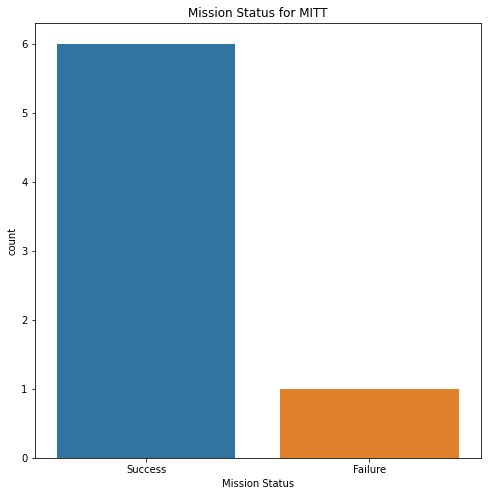

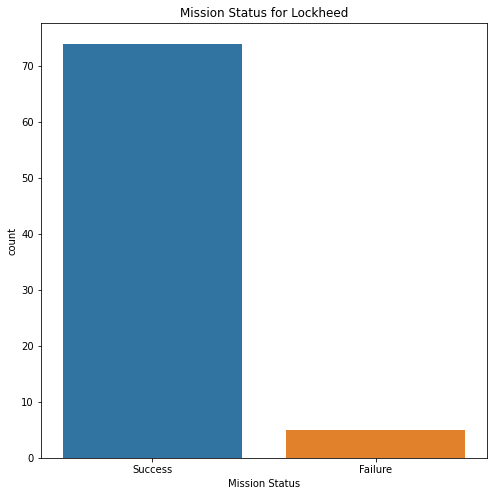

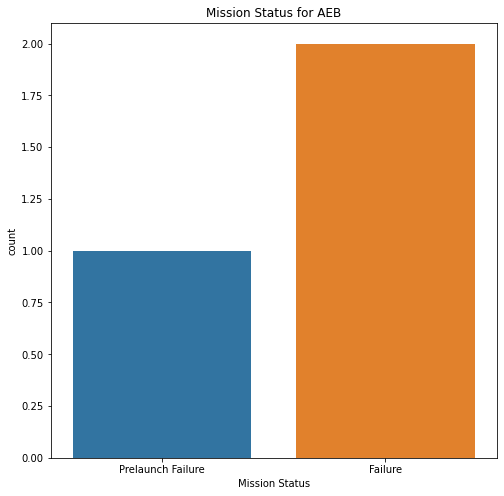

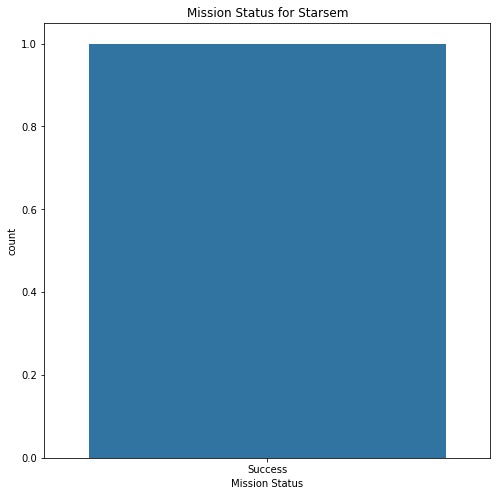

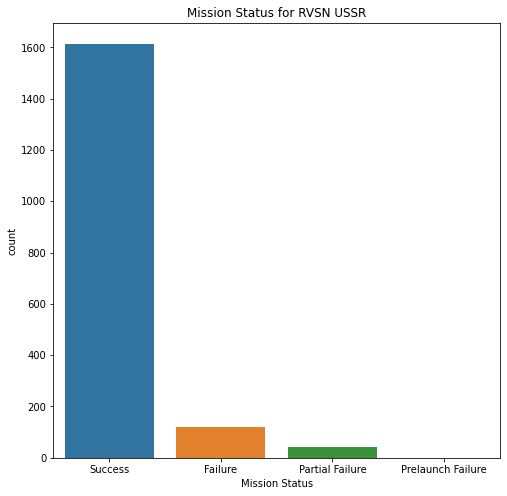

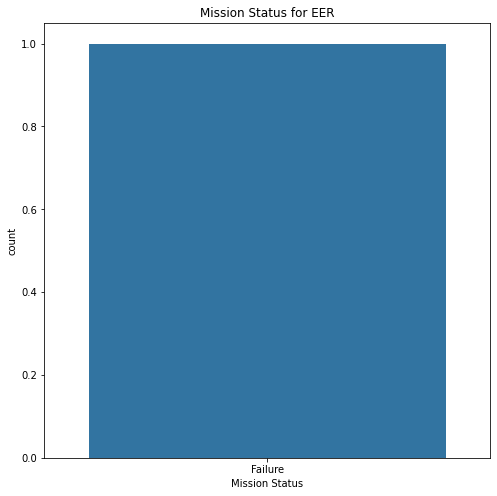

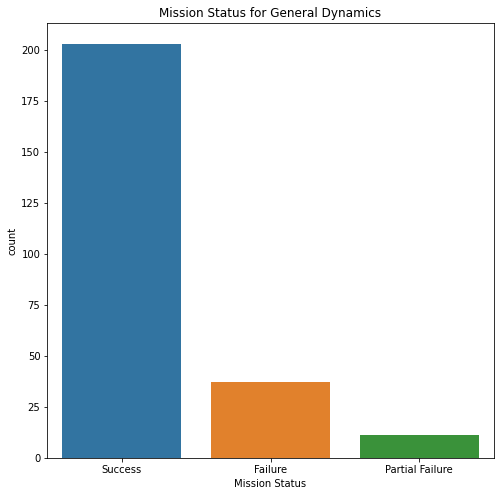

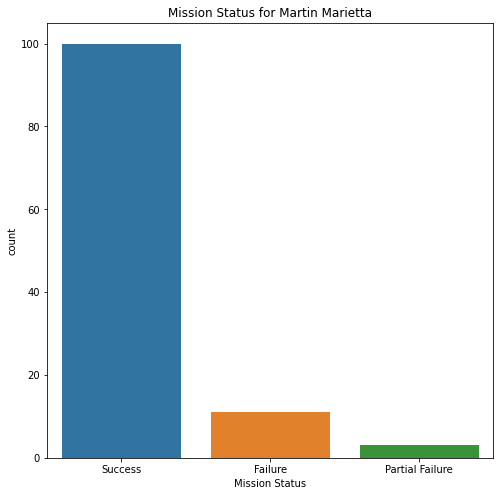

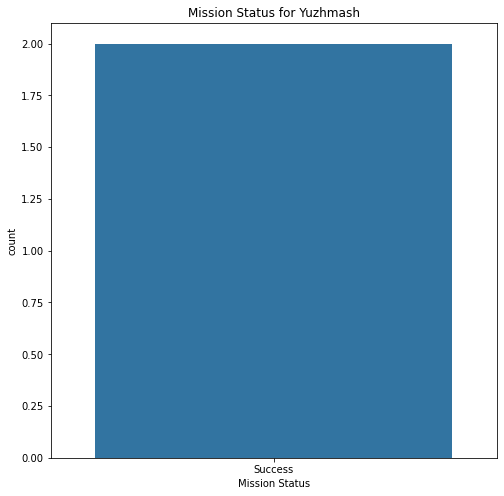

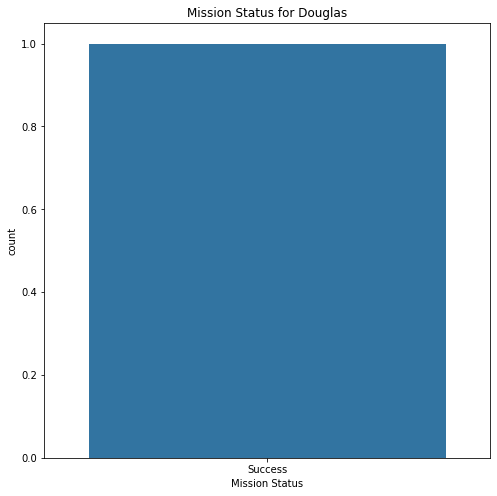

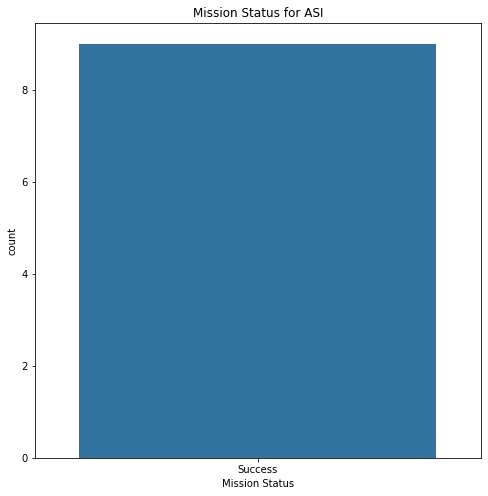

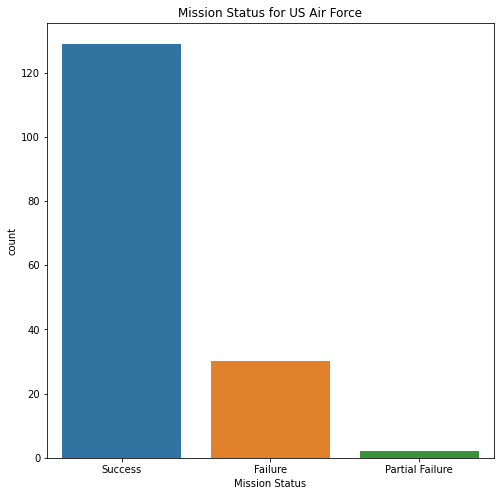

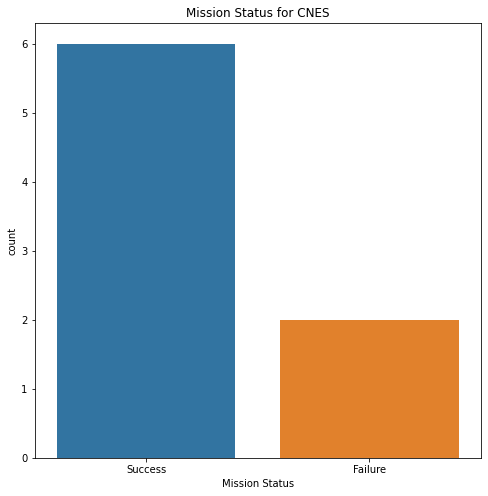

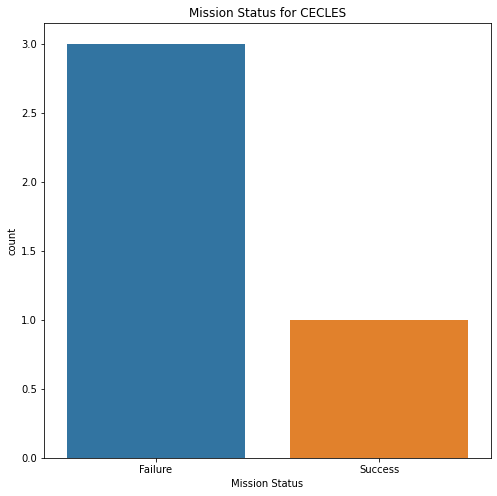

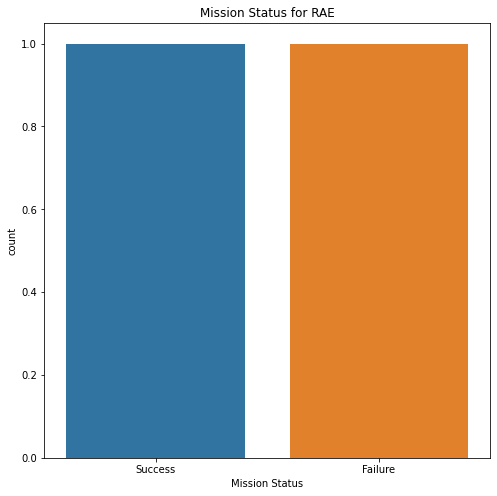

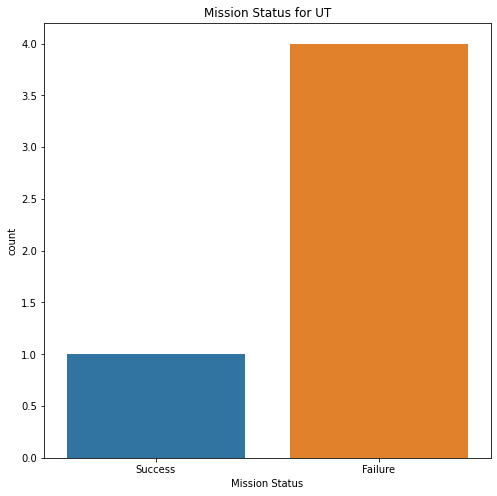

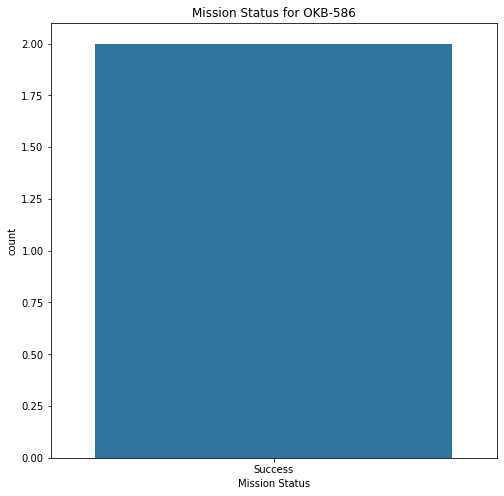

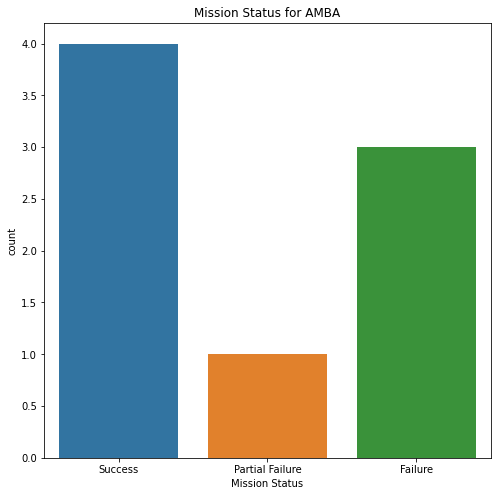

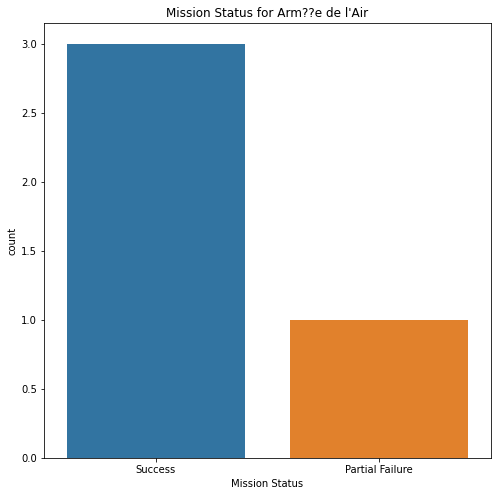

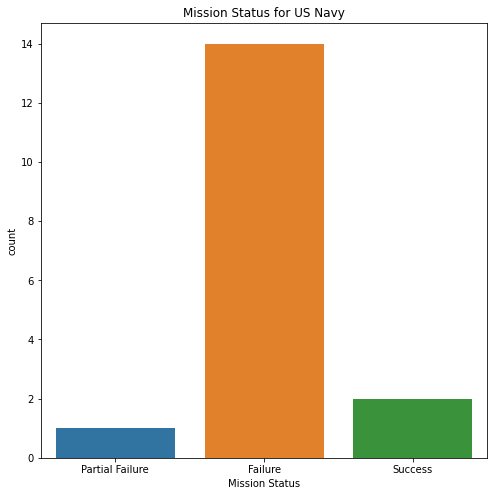

In [15]:
#### finding distributions of space missions for each company
company_list= space_df['Company Name'].unique()
for company in company_list:
    tempdf= space_df[space_df['Company Name']==company]
    plt.figure(figsize=(8,8))
    plt.title(f'Mission Status for {company}')
    sb.countplot(data=tempdf,x='Mission Status')
    plt.show()
    

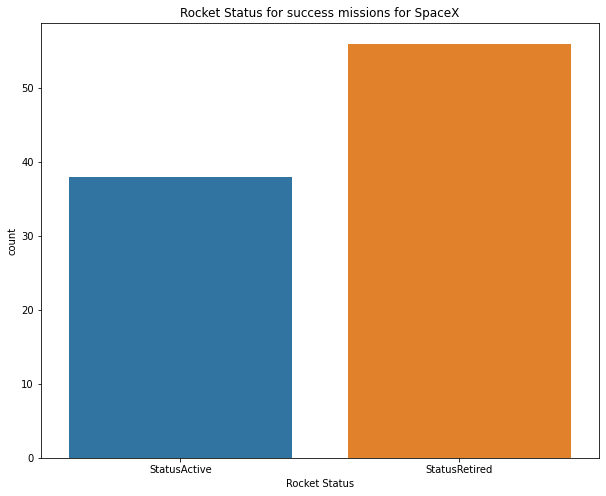

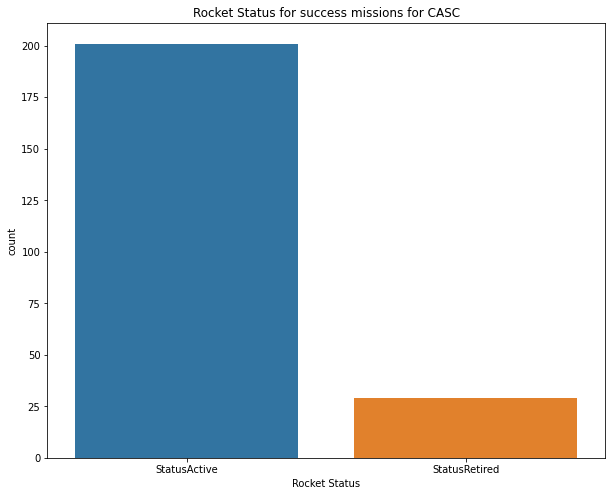

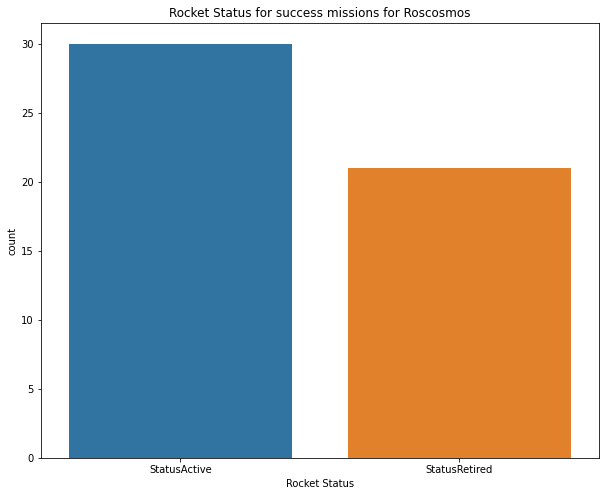

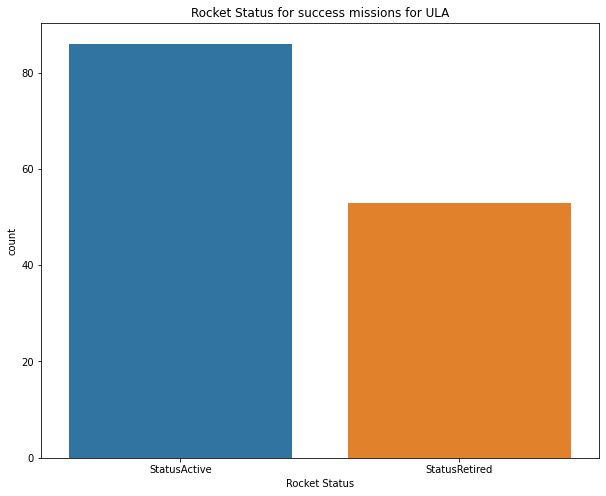

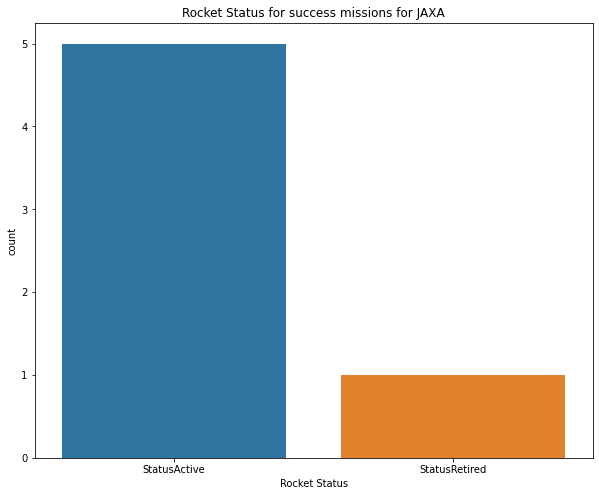

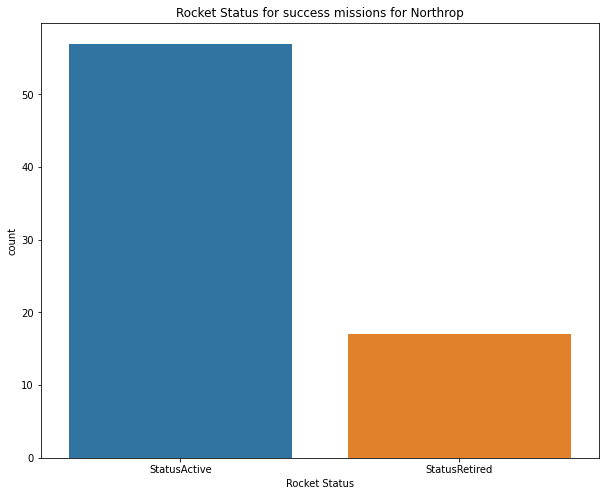

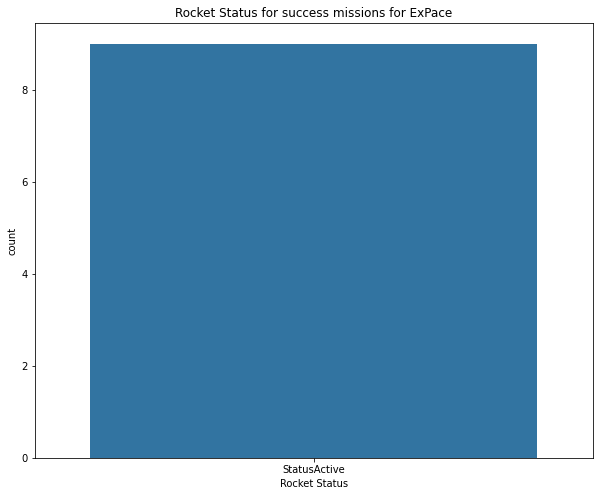

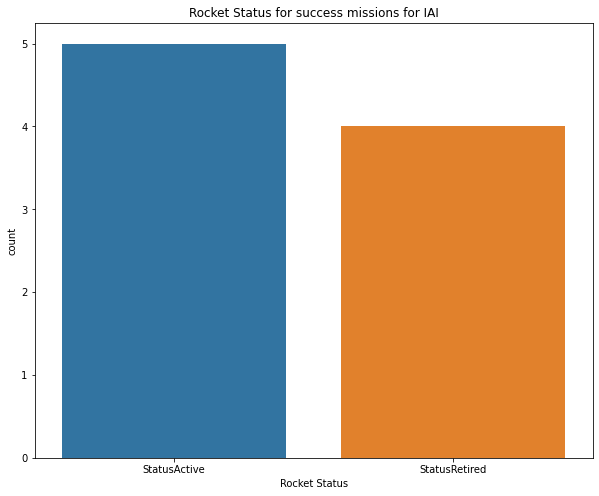

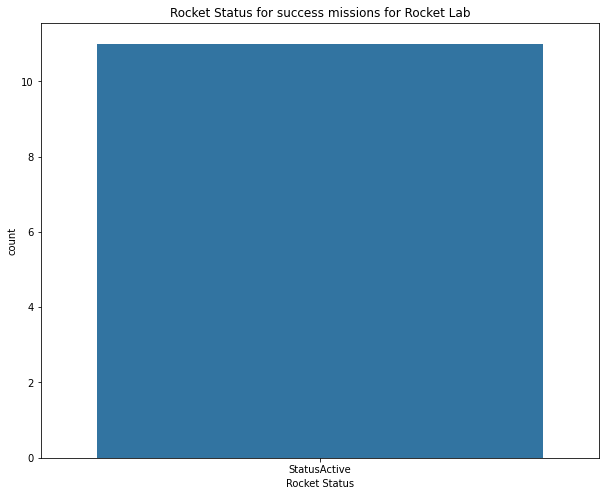

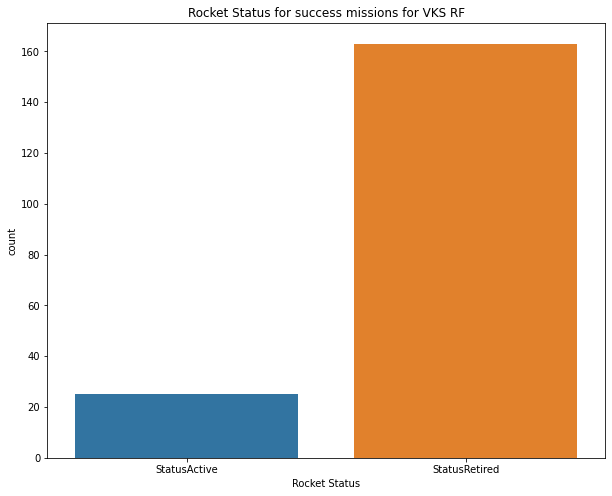

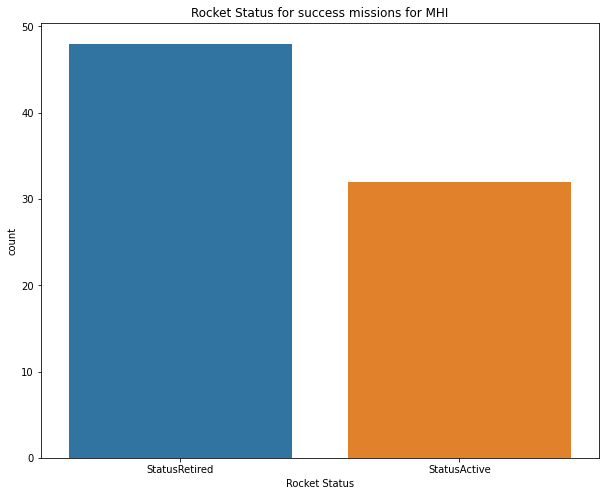

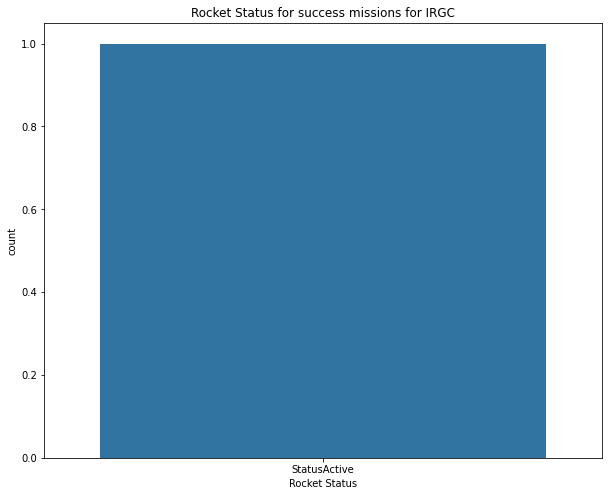

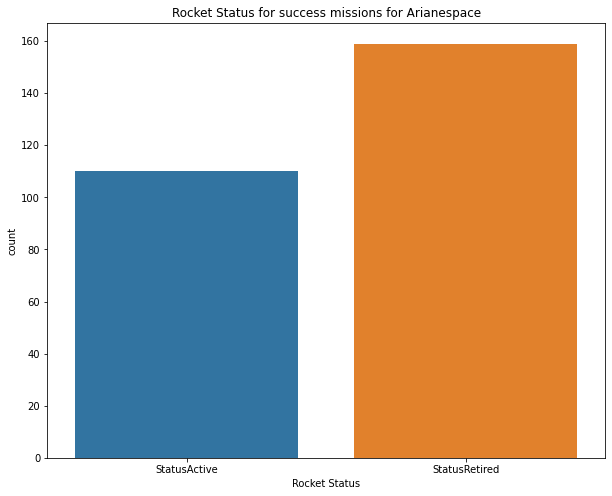

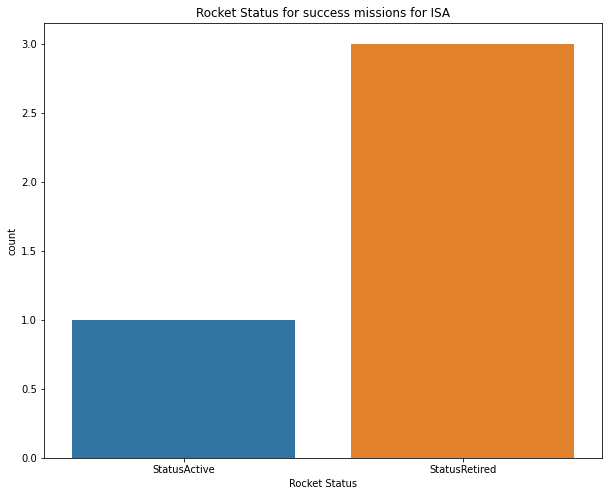

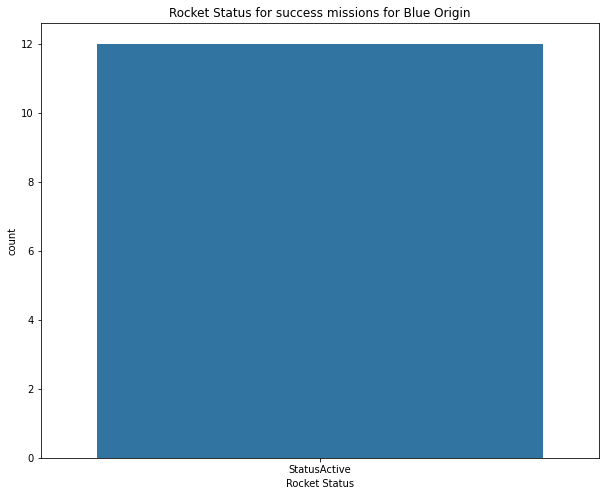

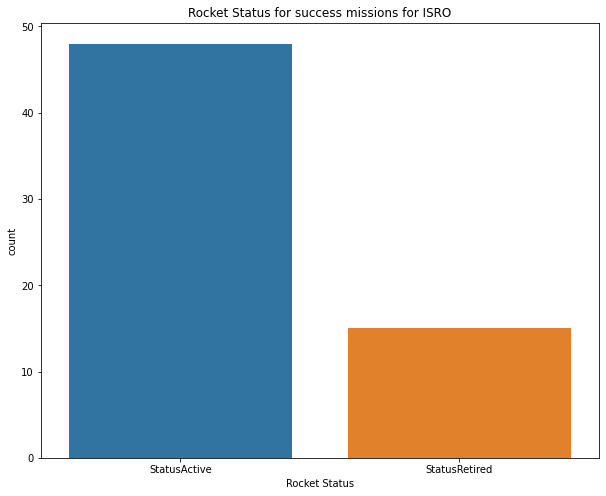

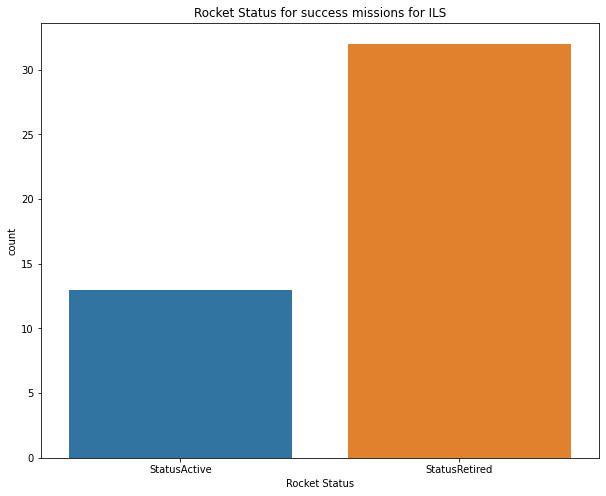

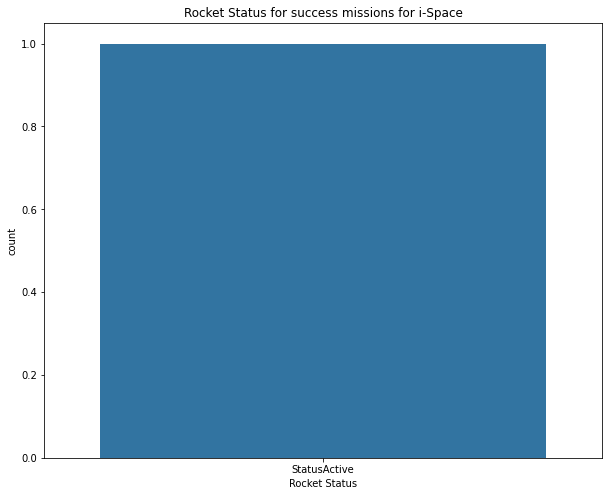

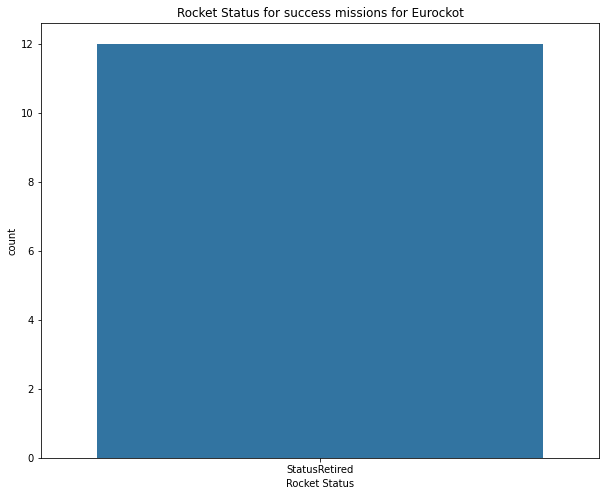

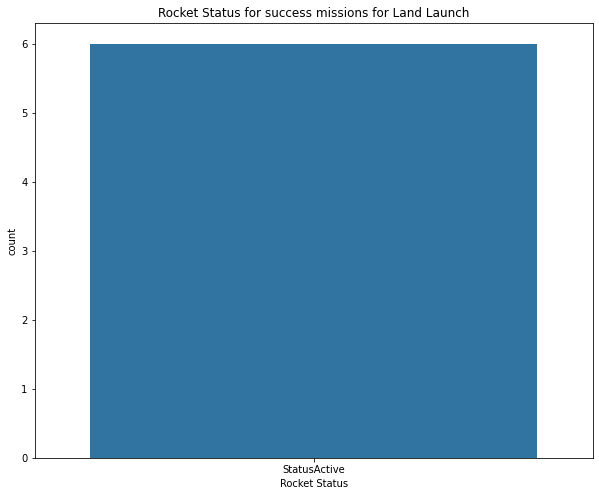

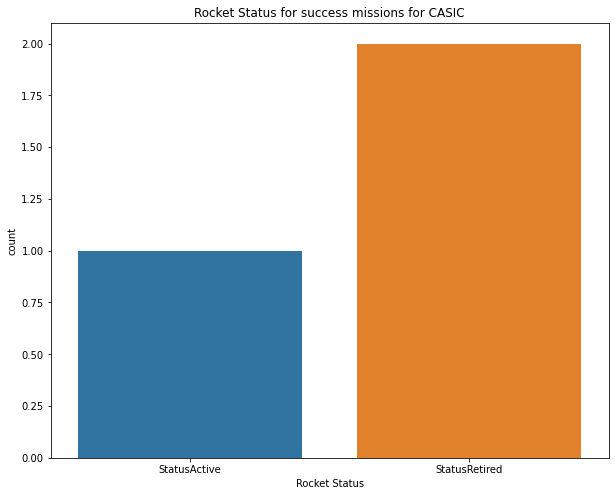

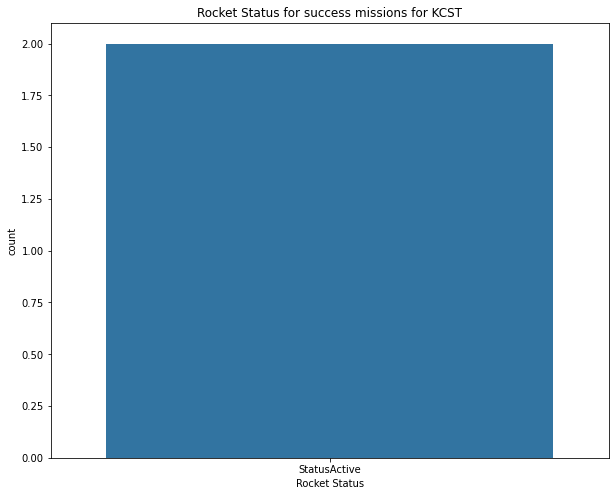

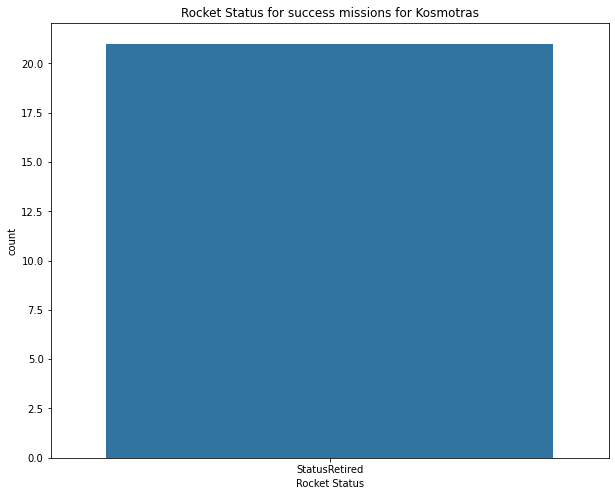

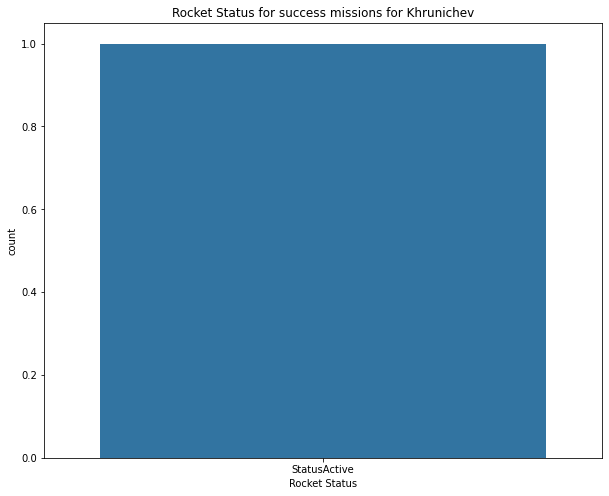

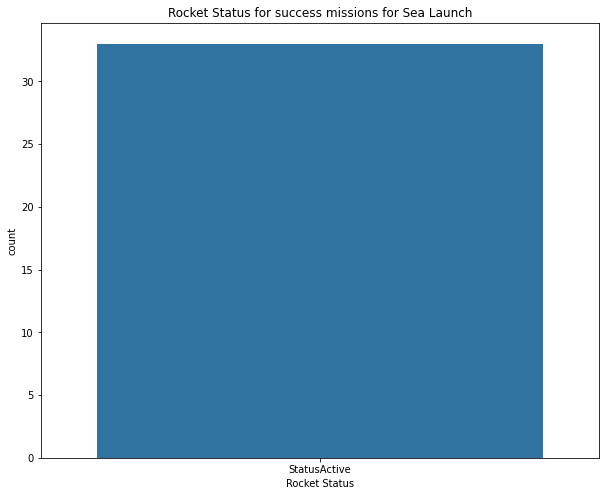

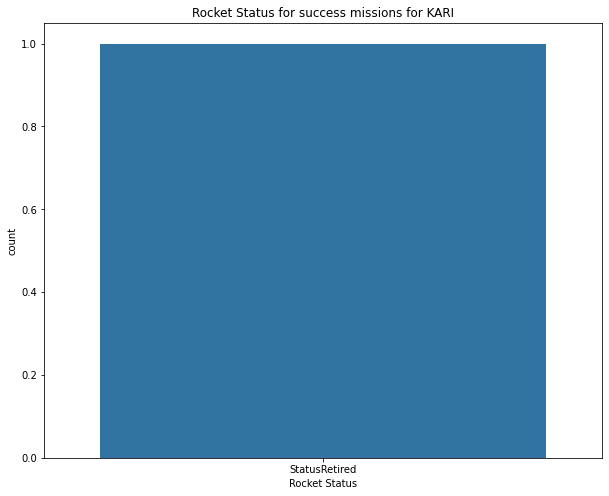

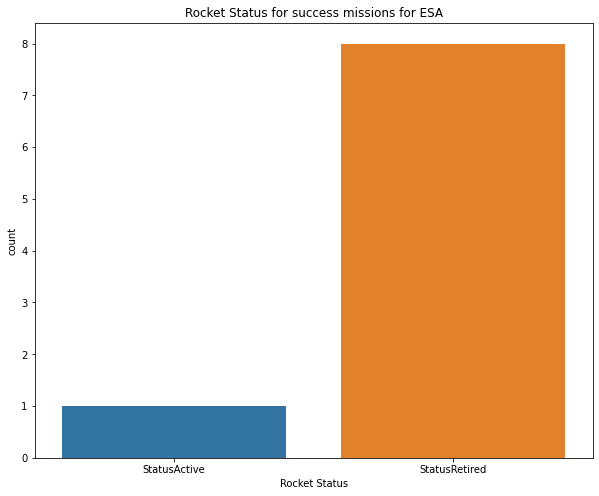

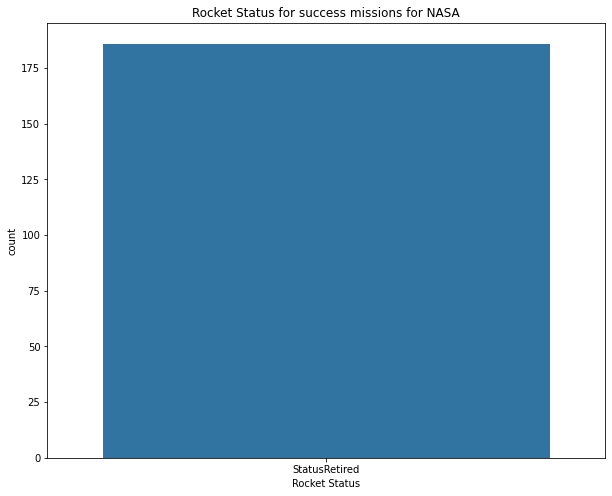

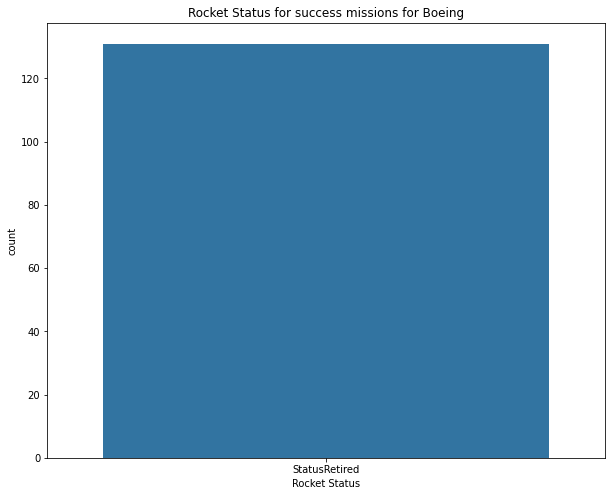

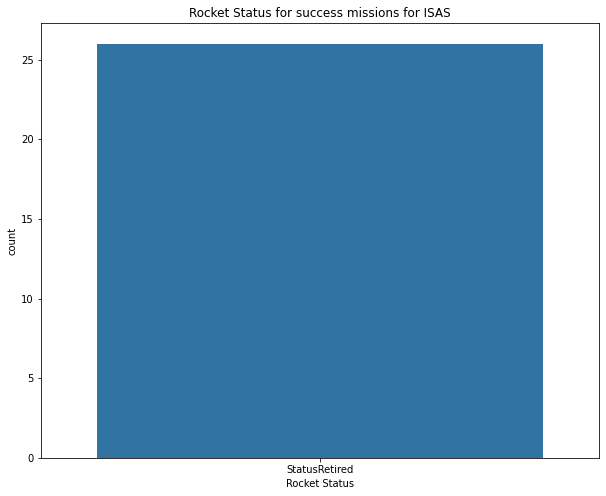

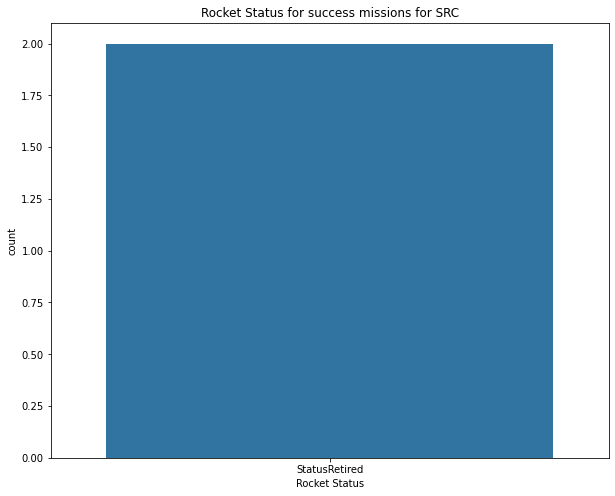

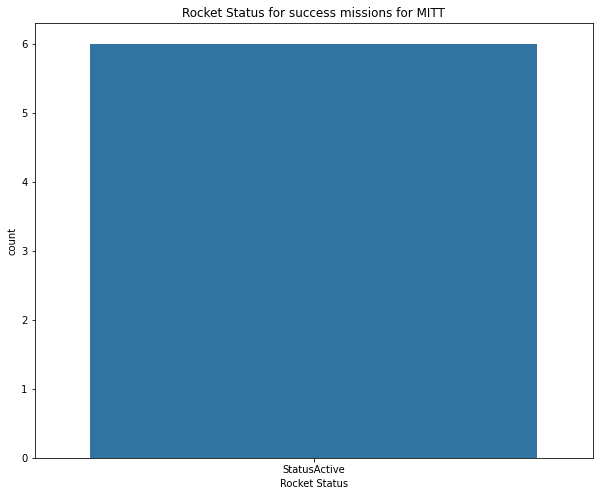

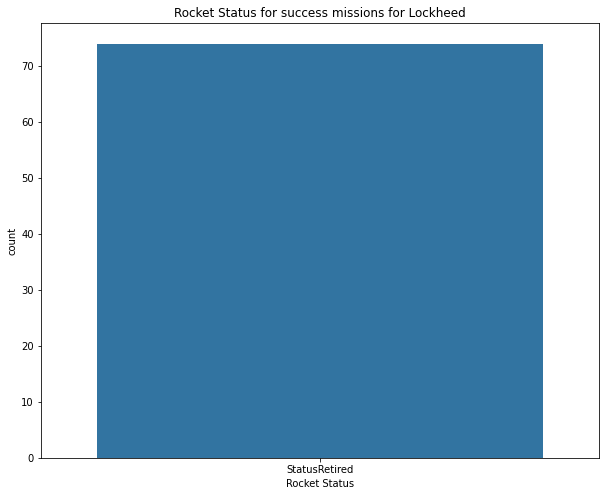

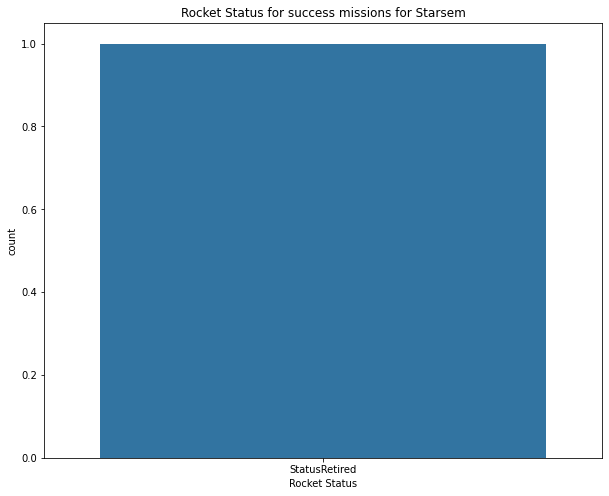

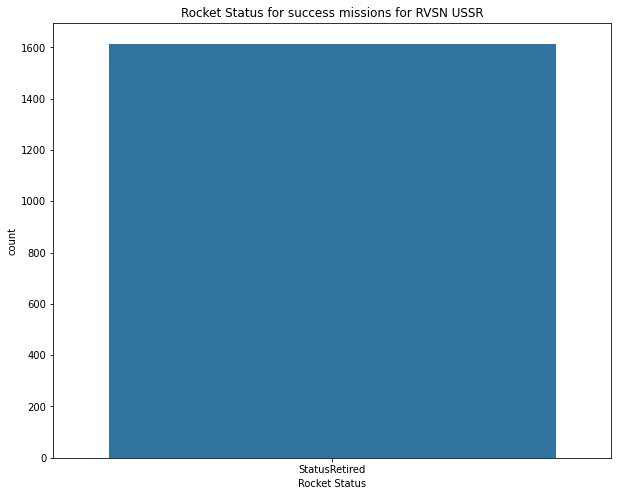

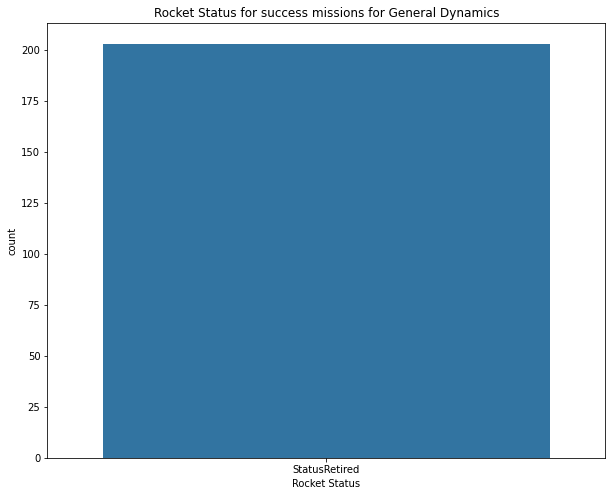

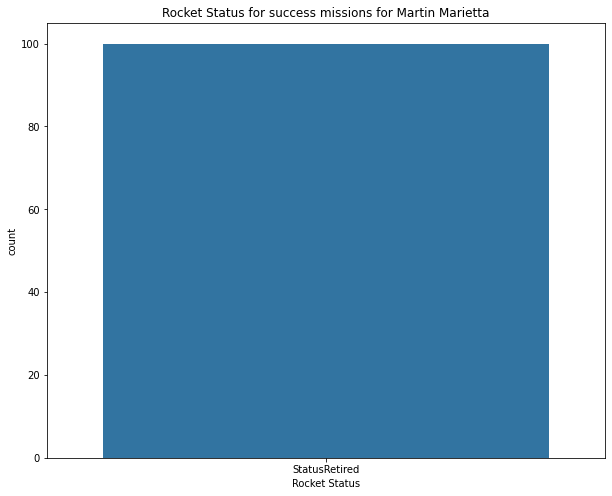

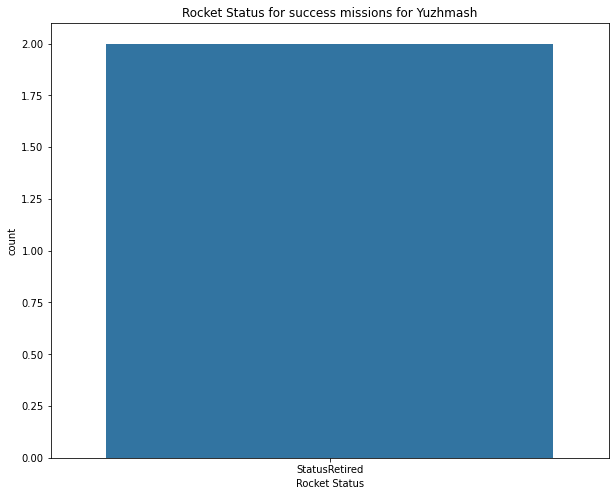

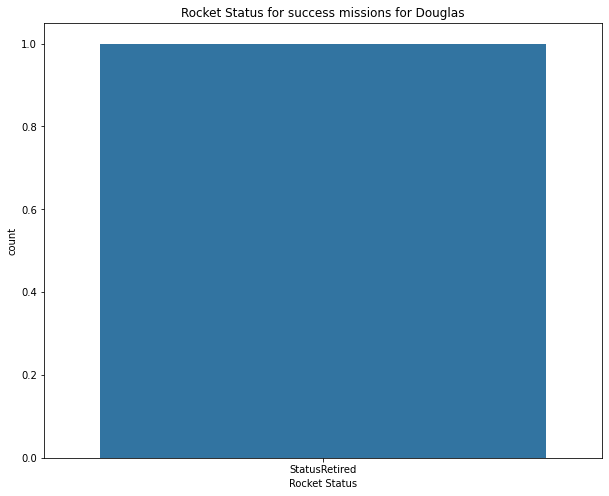

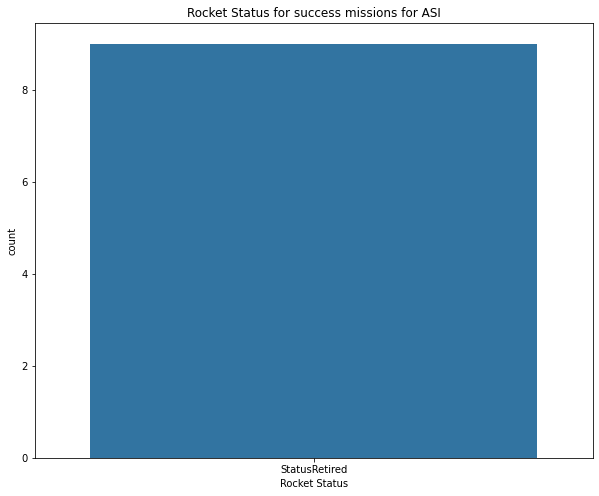

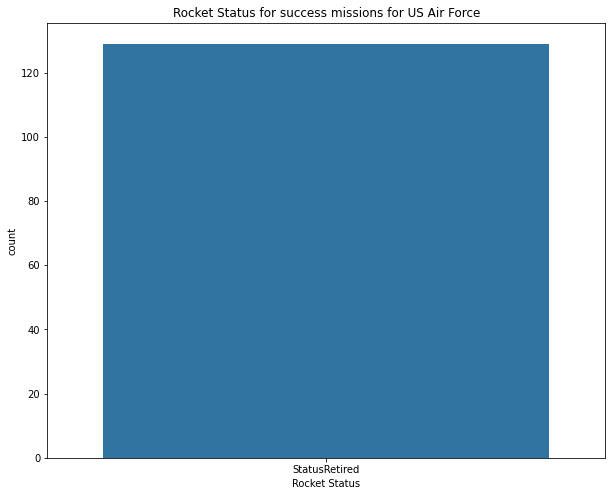

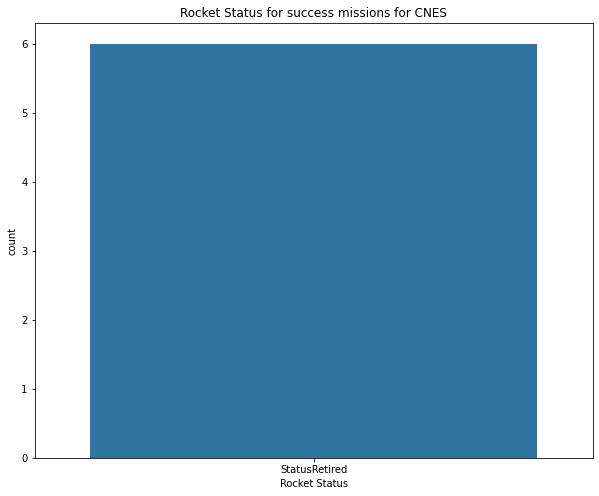

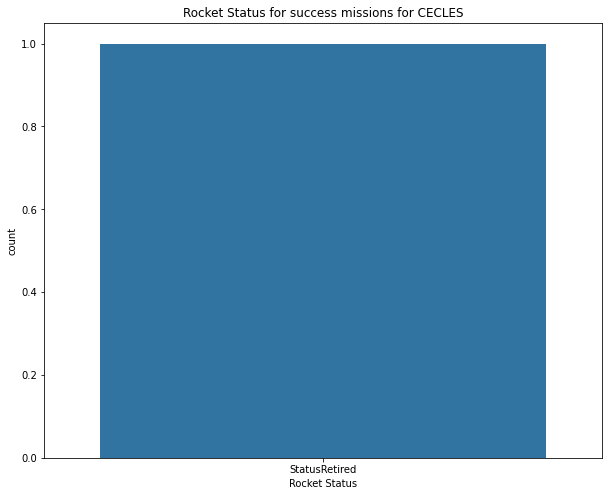

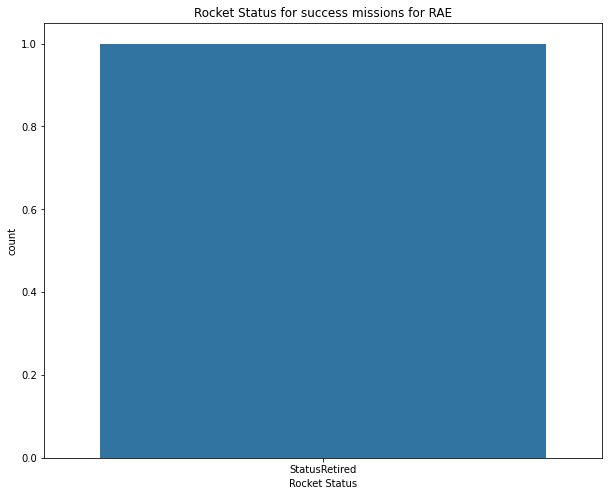

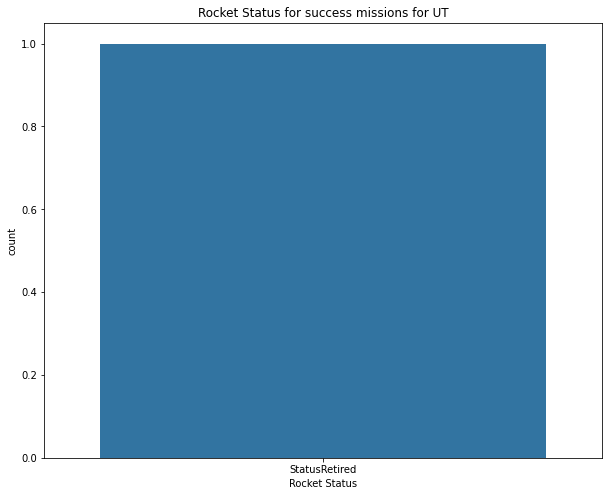

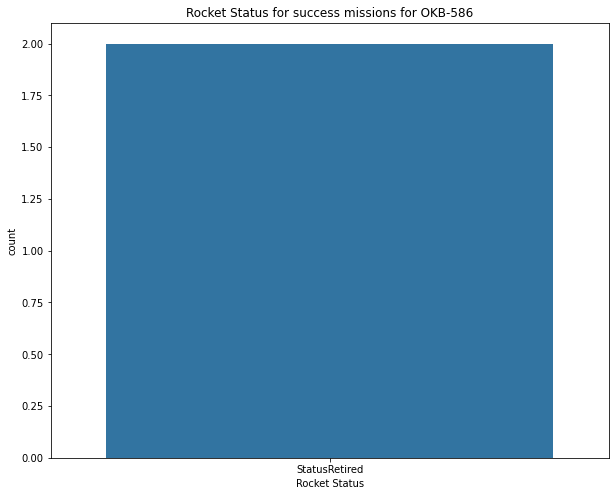

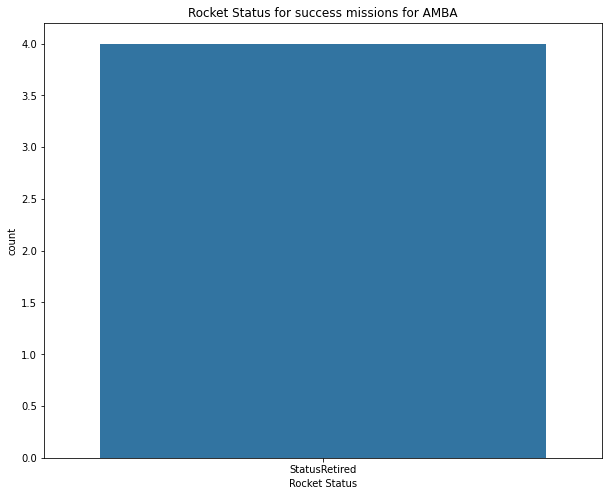

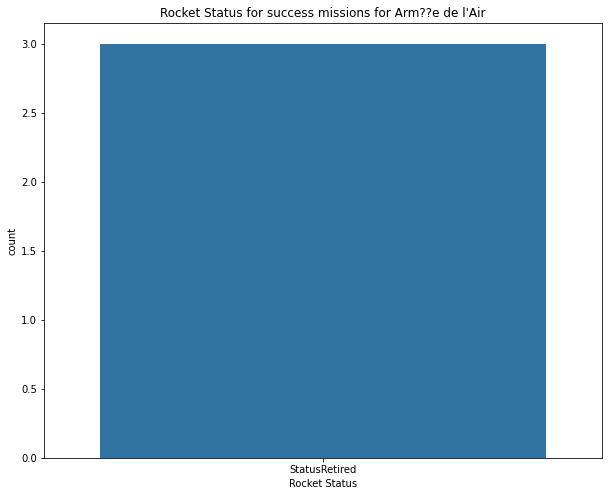

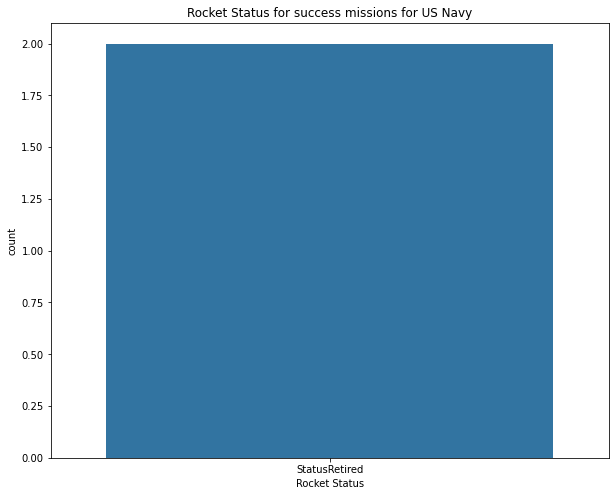

In [16]:
##### taking the success missions for each company and rocket status

for company in company_list:
    tempdf= space_df[(space_df['Mission Status']=='Success') &(space_df['Company Name']==company)]
    if tempdf.shape[0]!=0:
        plt.figure(figsize=(10,8))
        plt.title(f'Rocket Status for success missions for {company}')
        sb.countplot(data=tempdf,x='Rocket Status')
        plt.show()
    



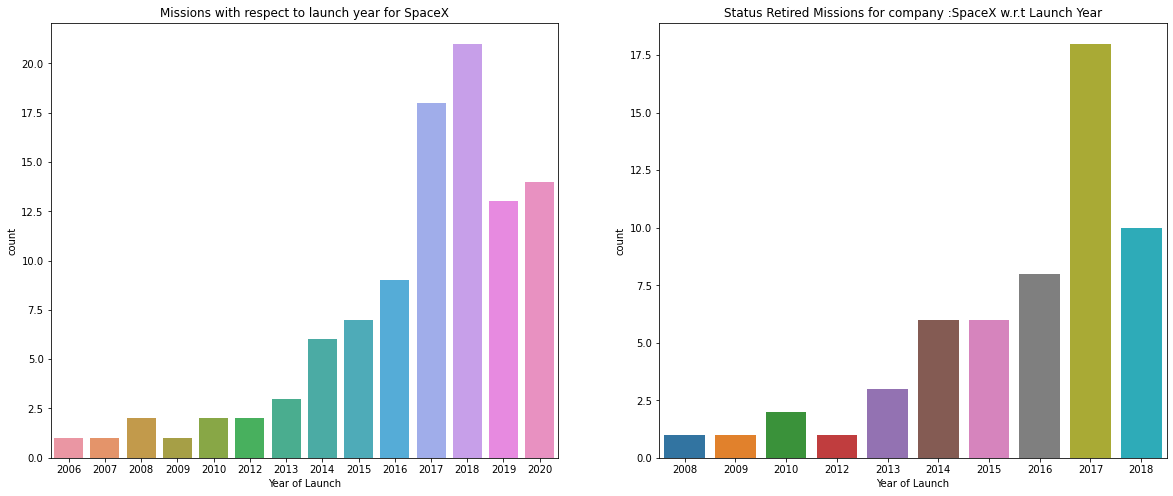

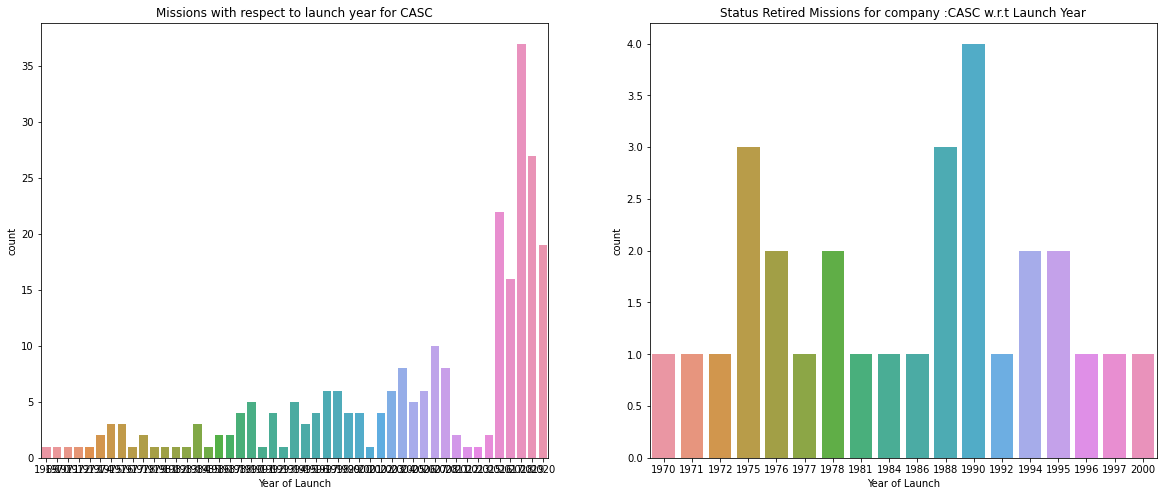

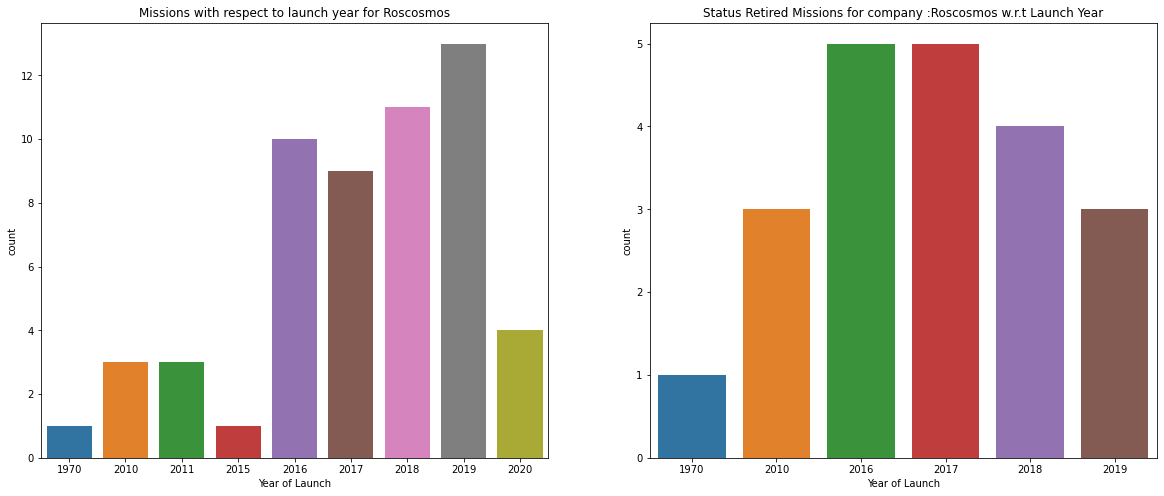

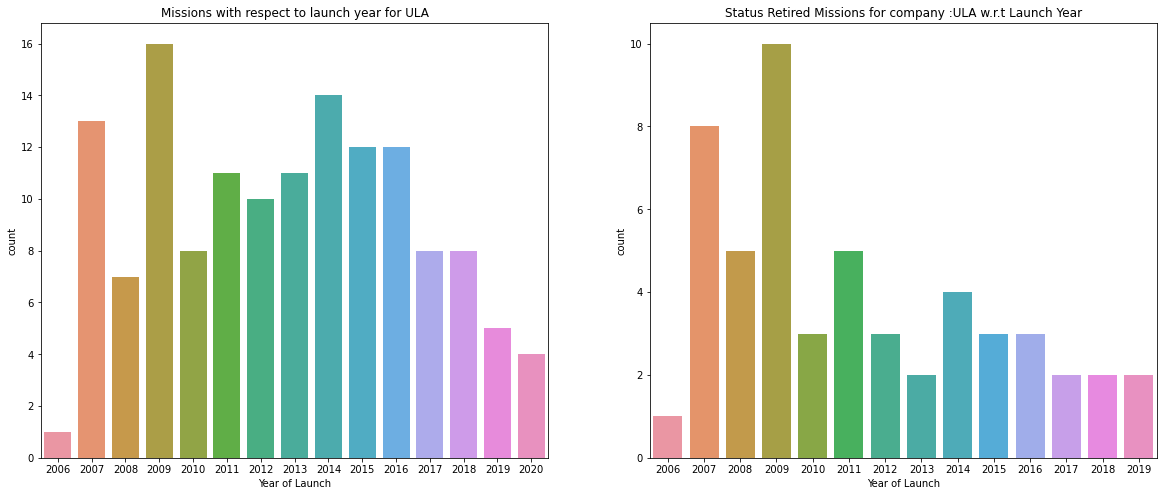

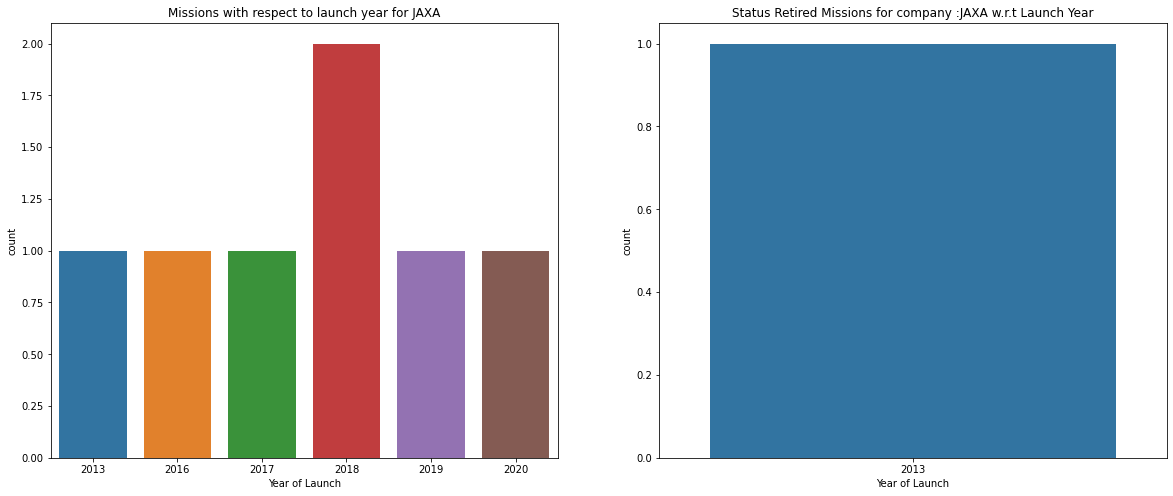

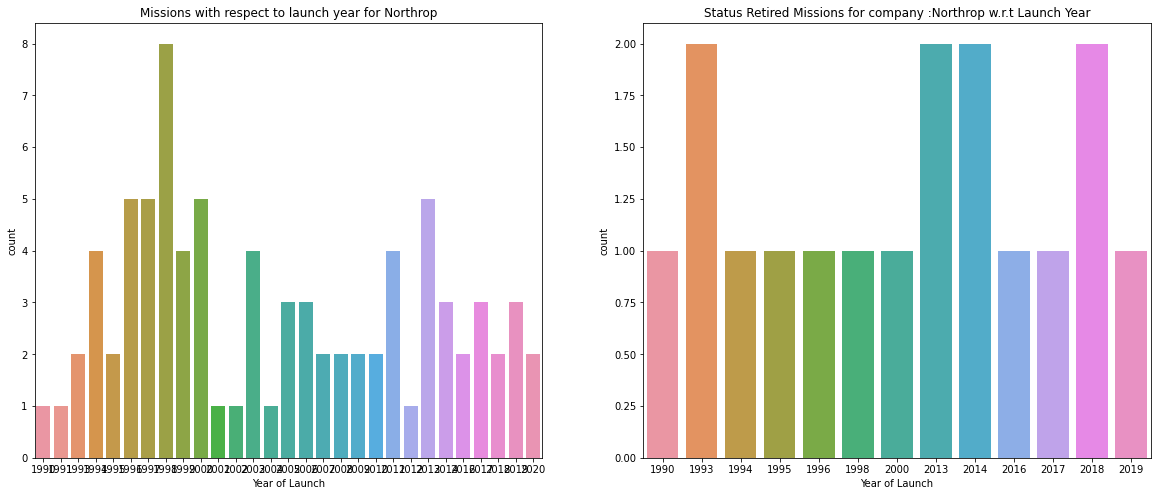

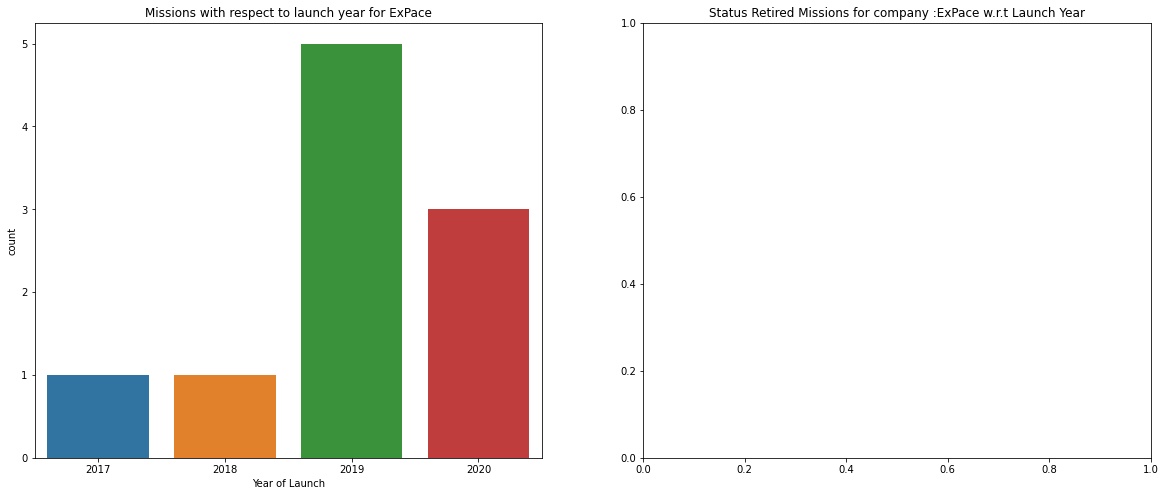

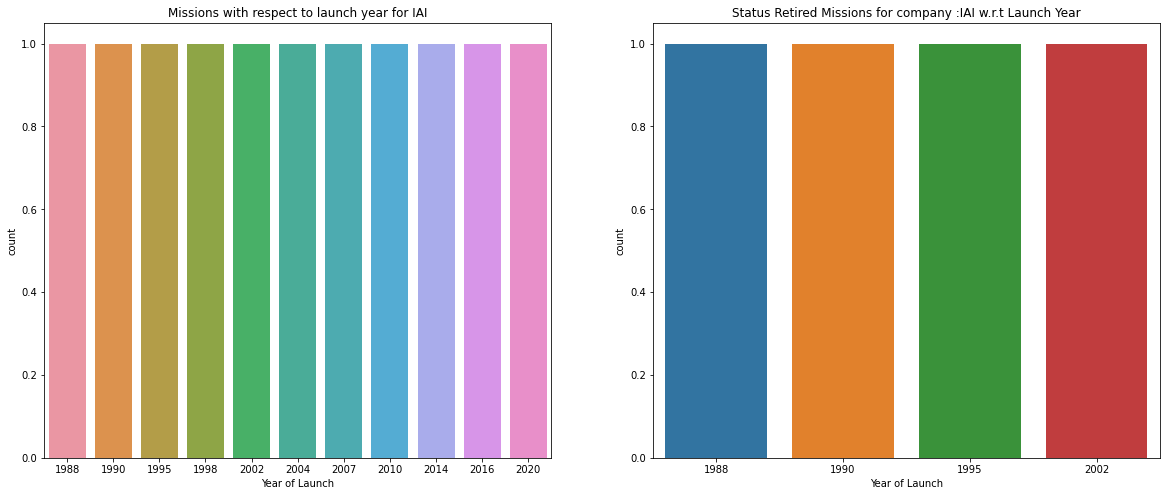

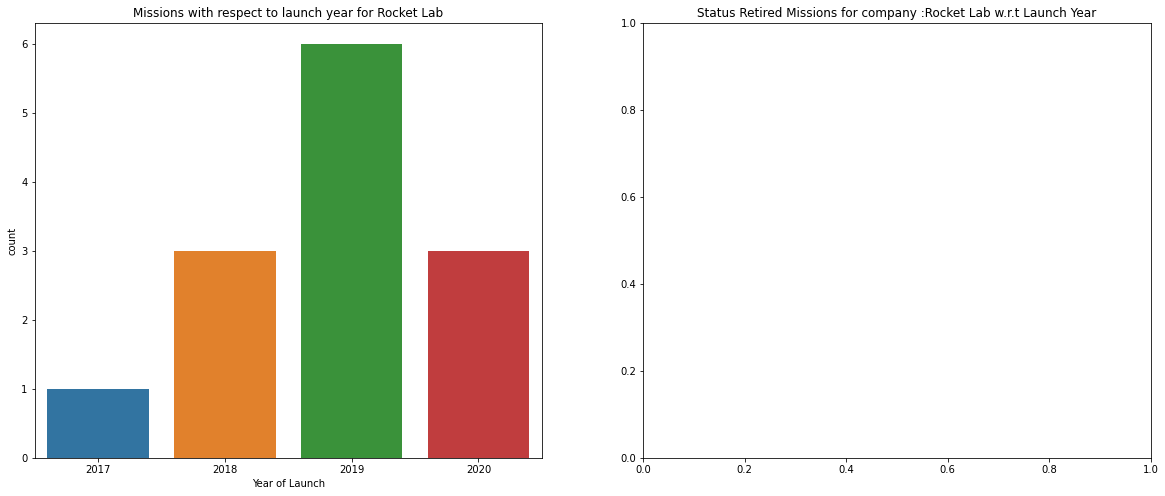

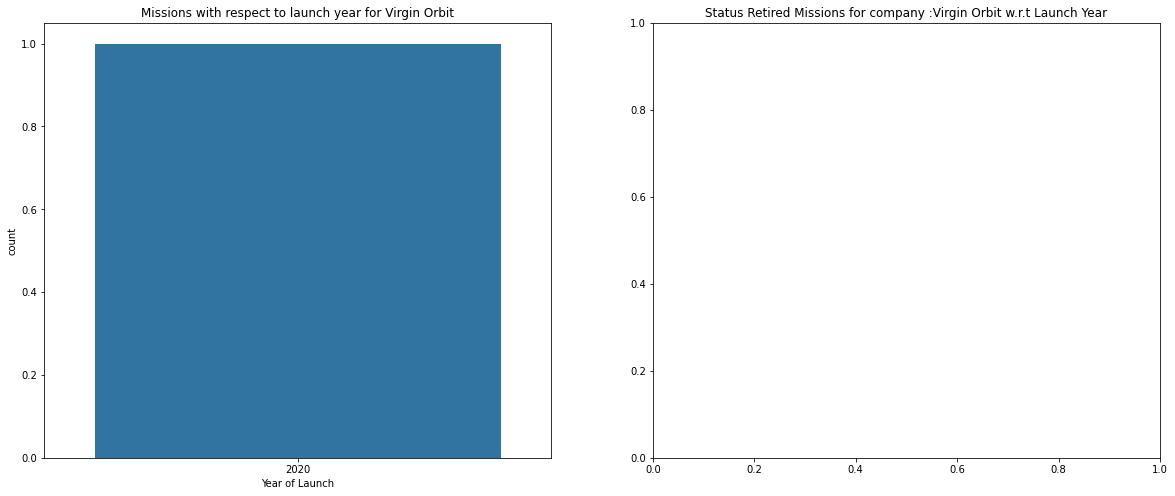

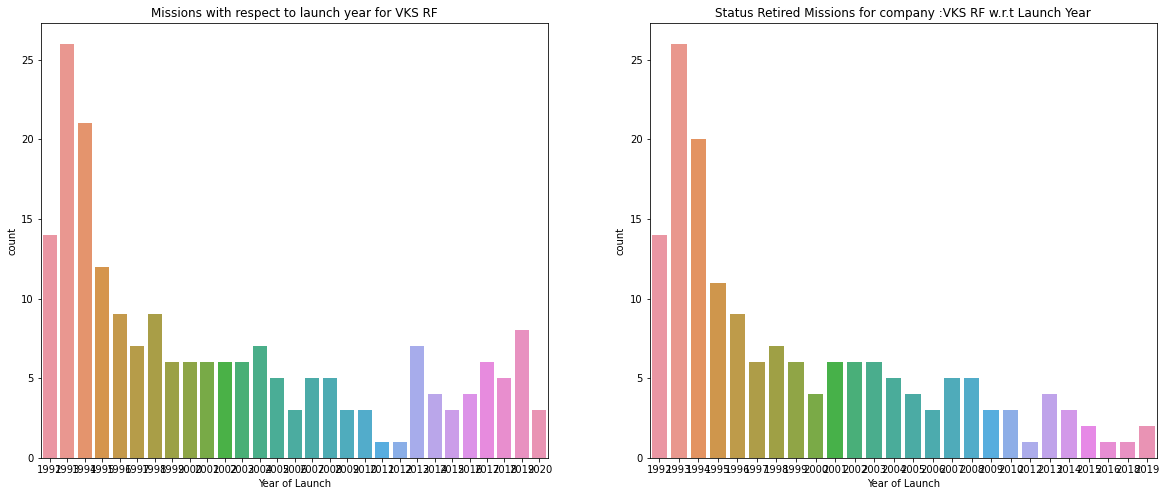

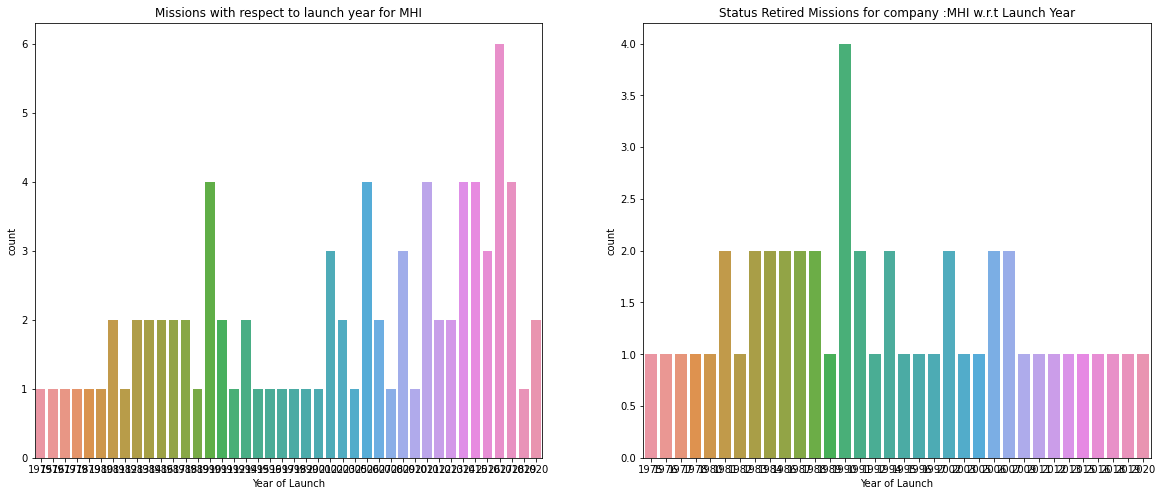

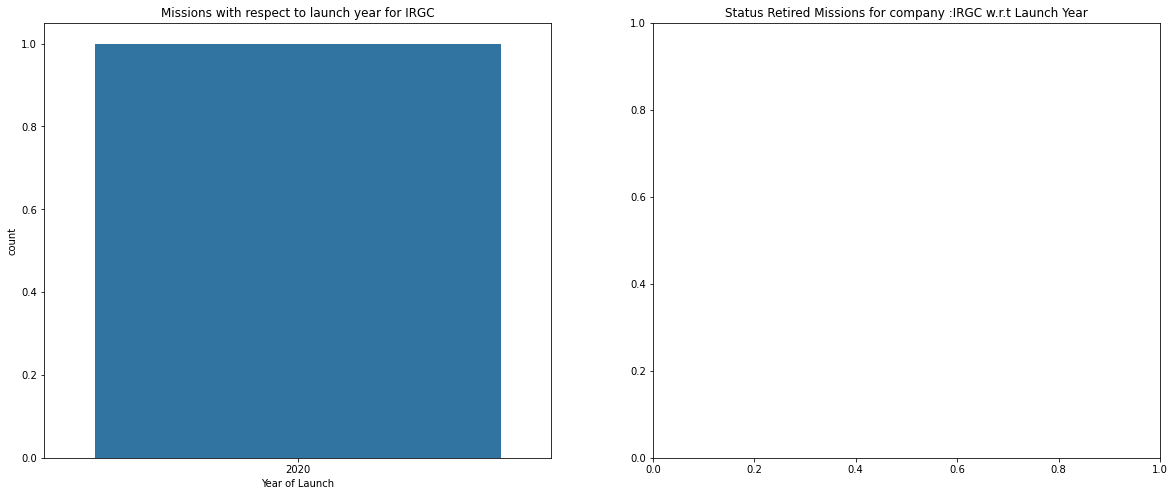

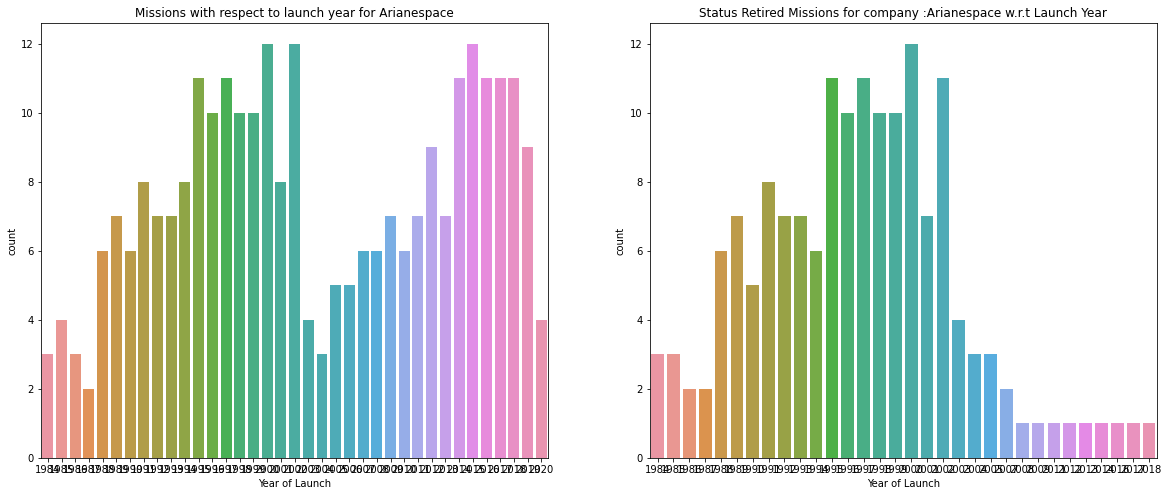

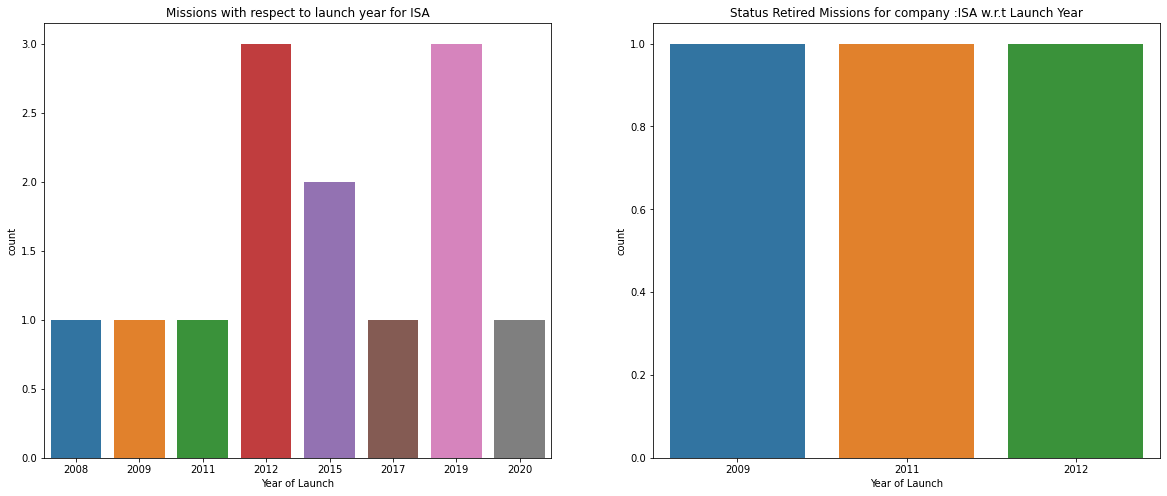

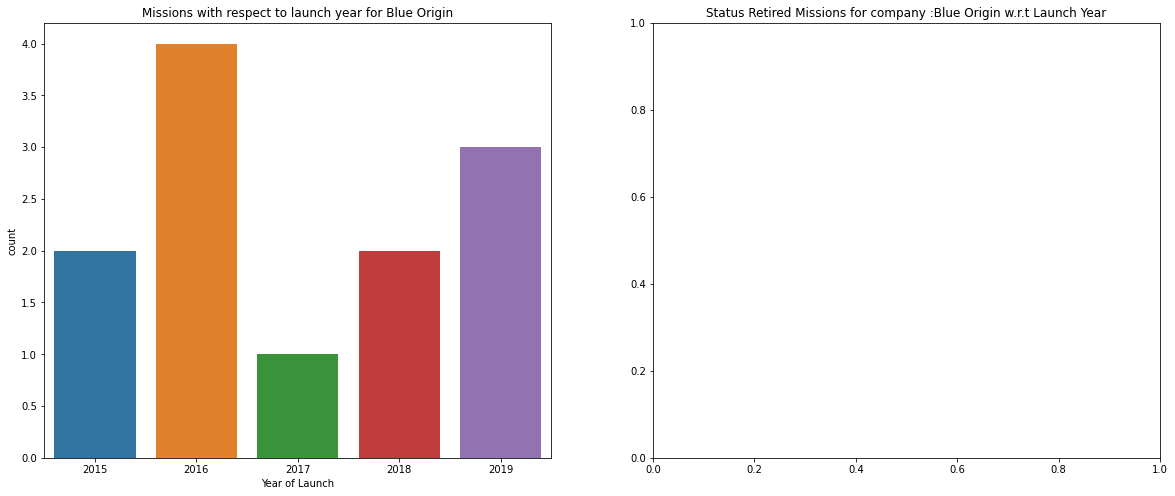

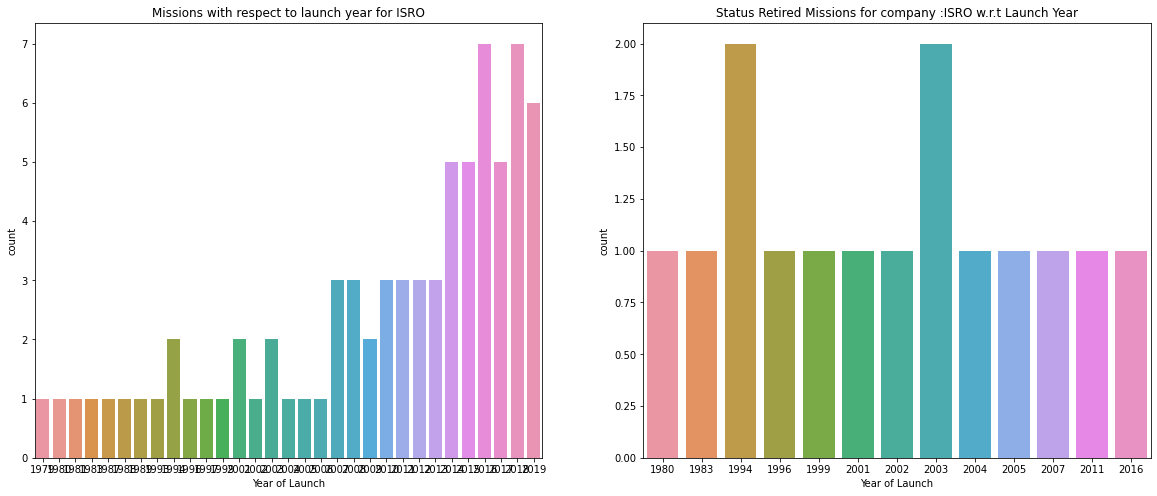

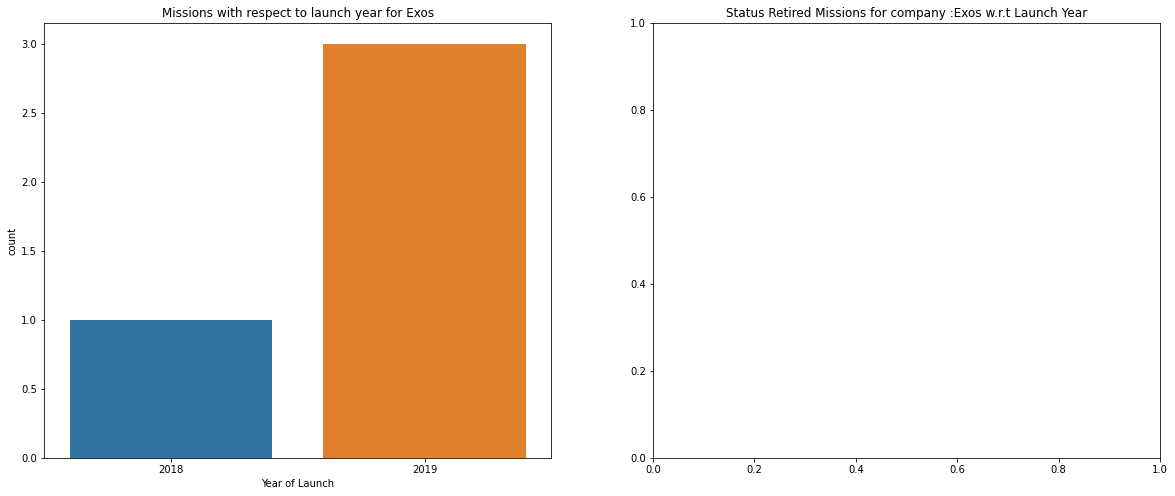

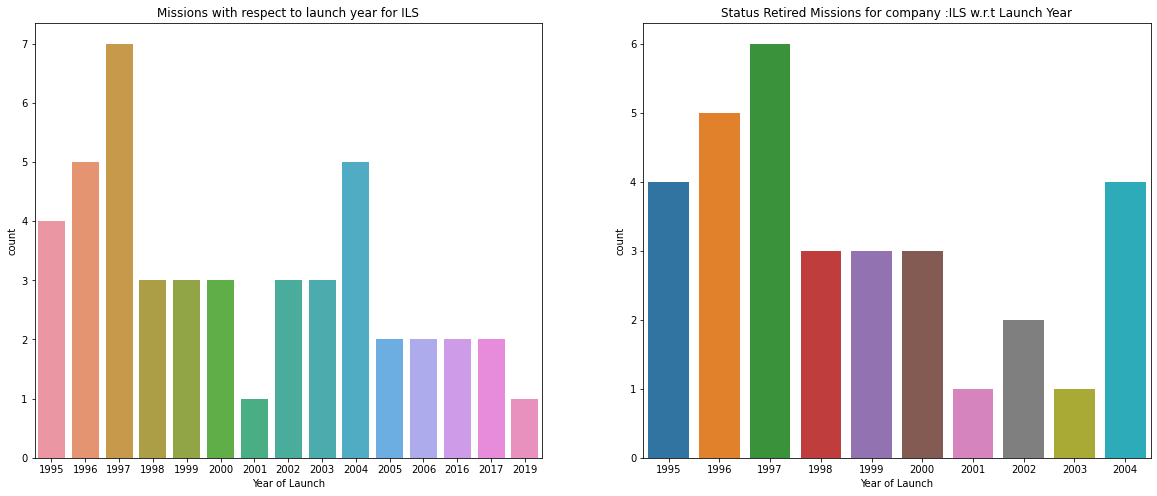

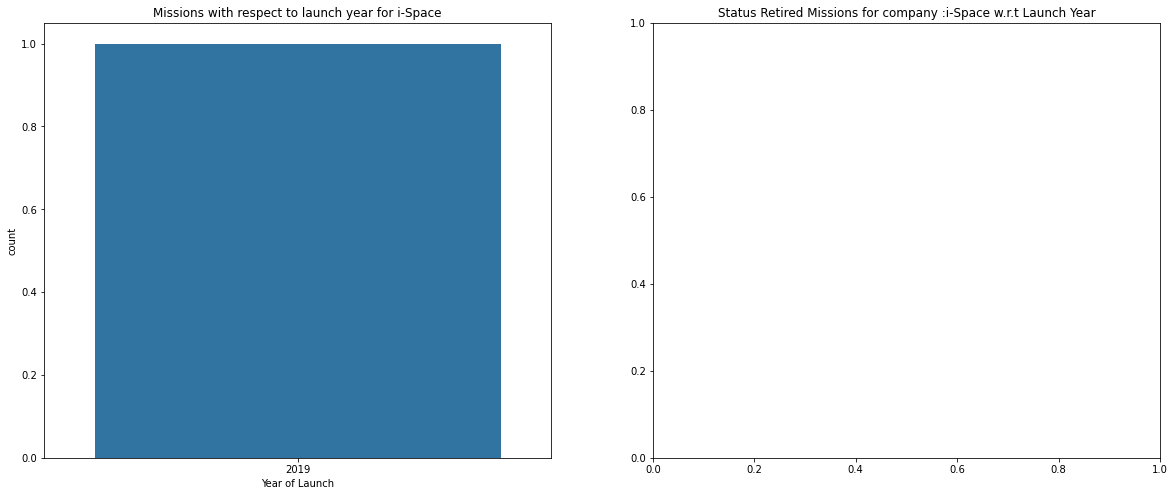

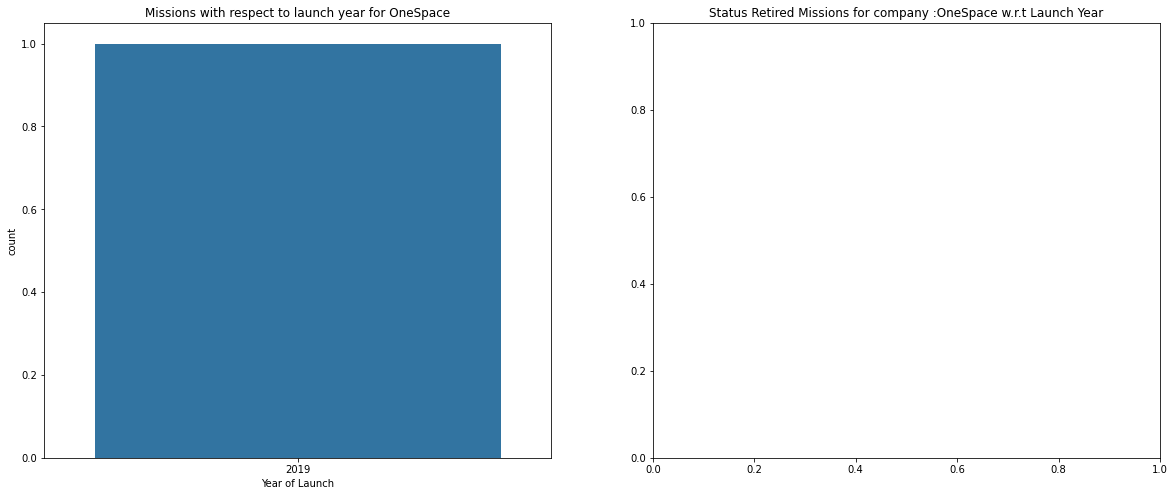

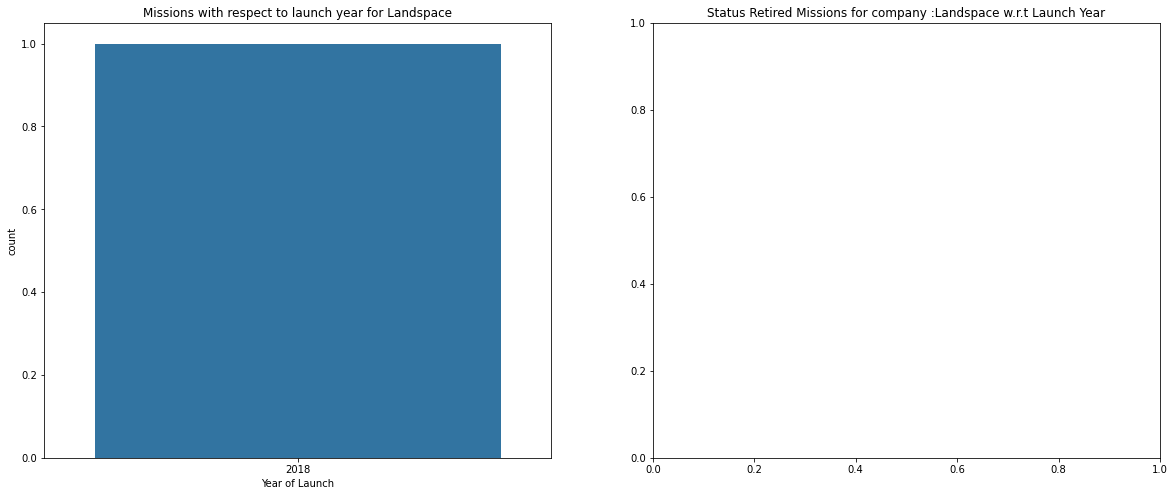

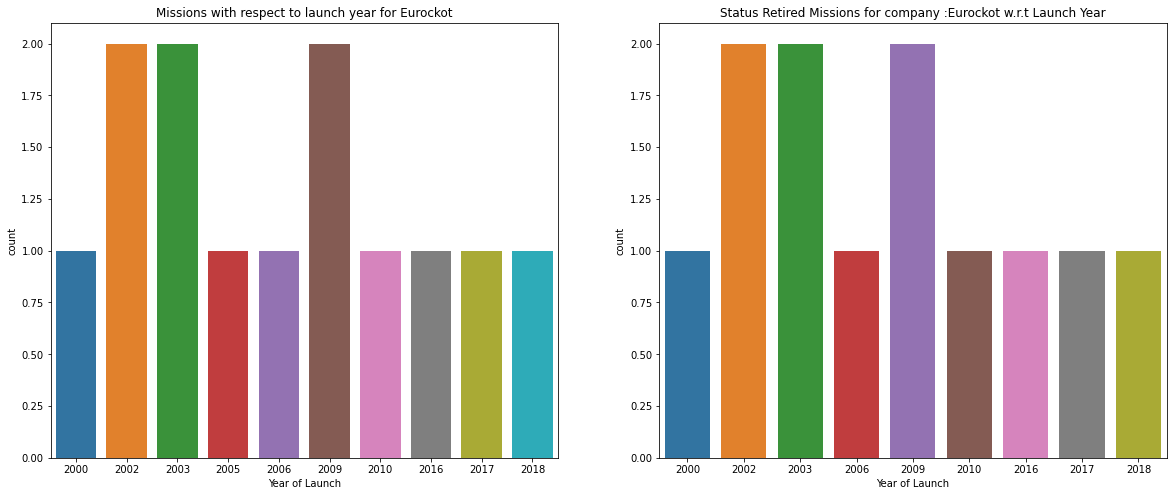

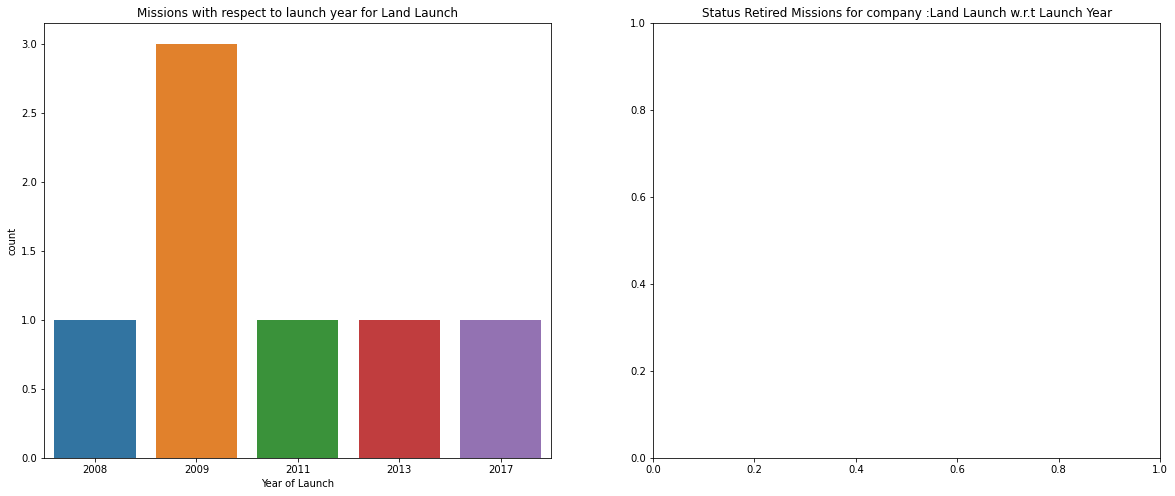

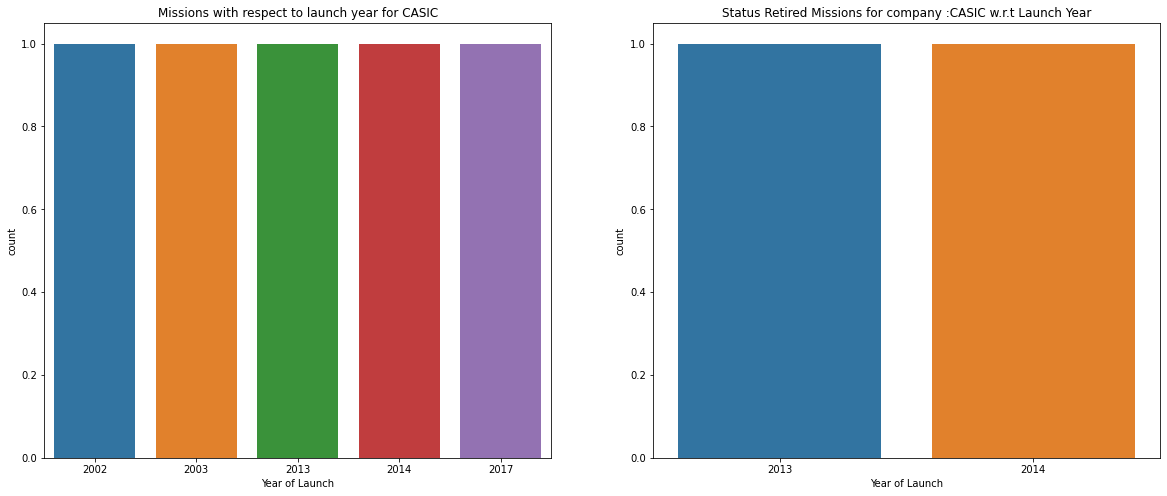

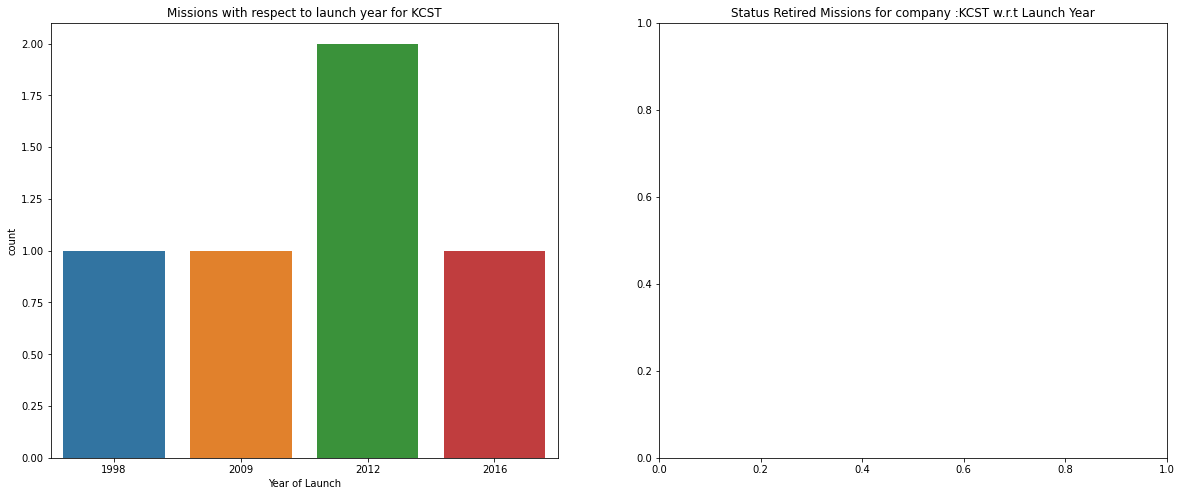

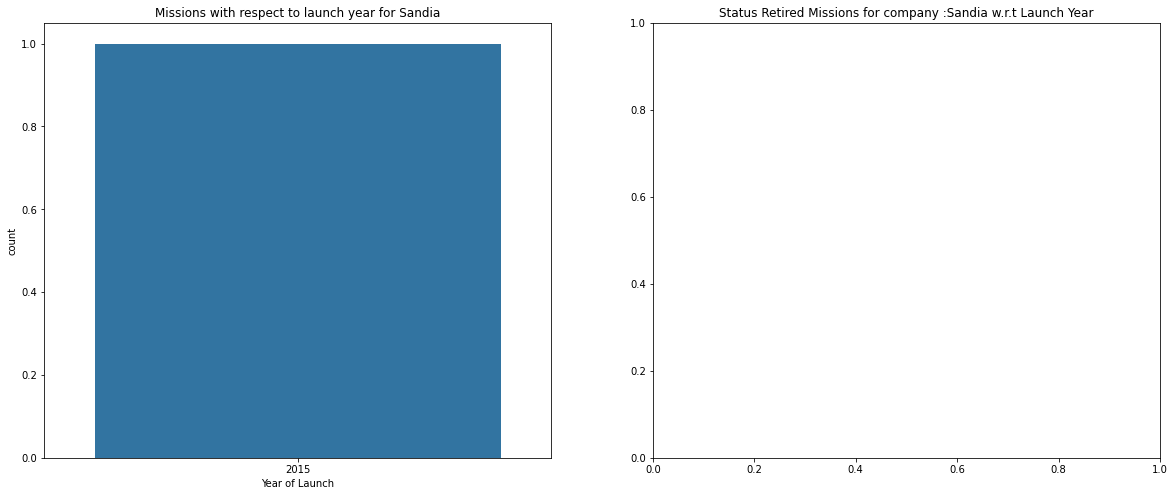

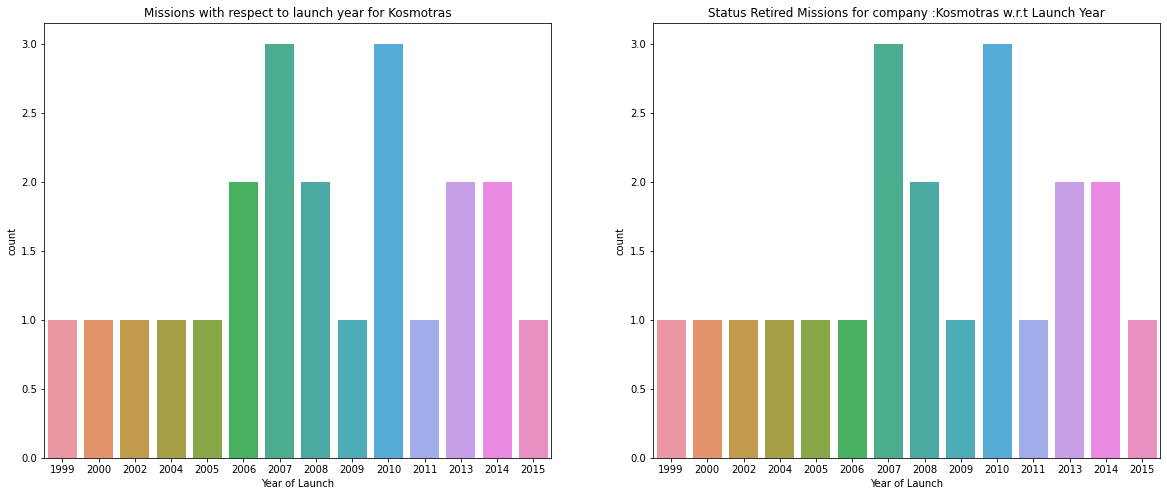

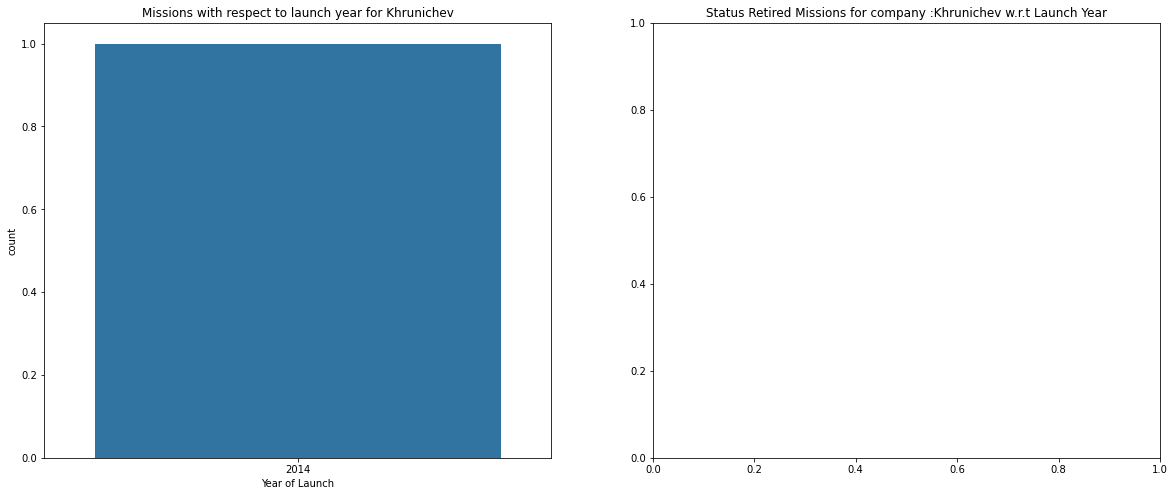

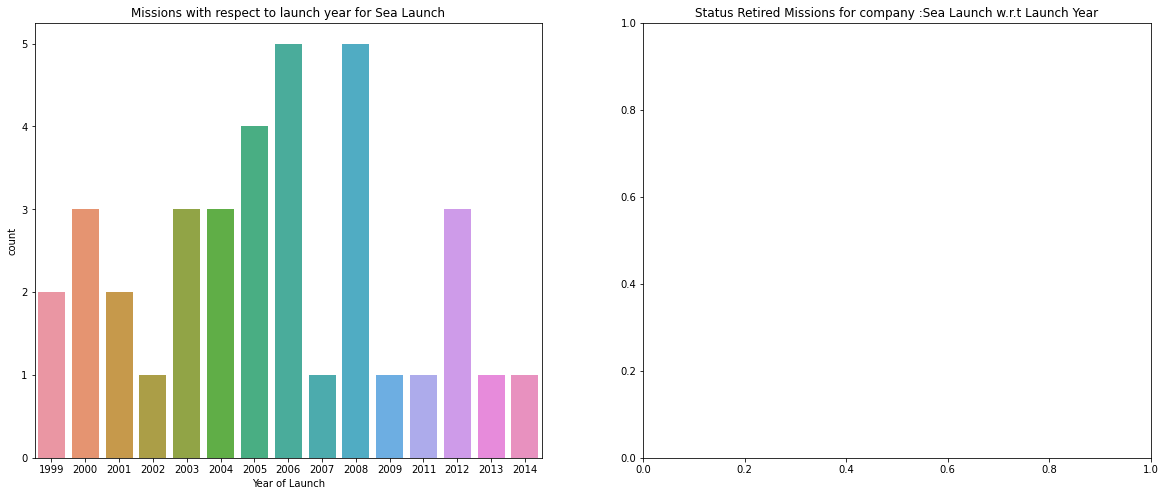

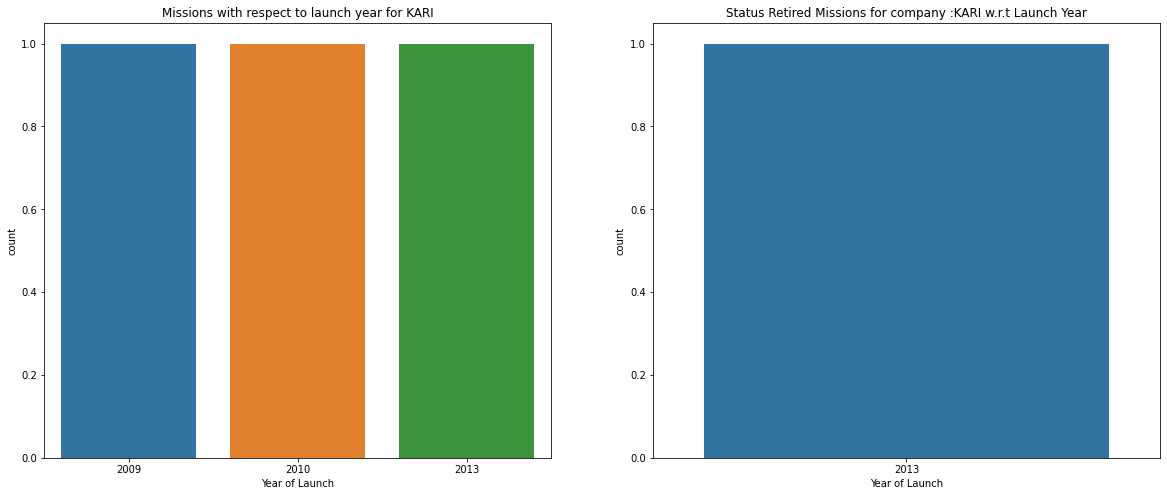

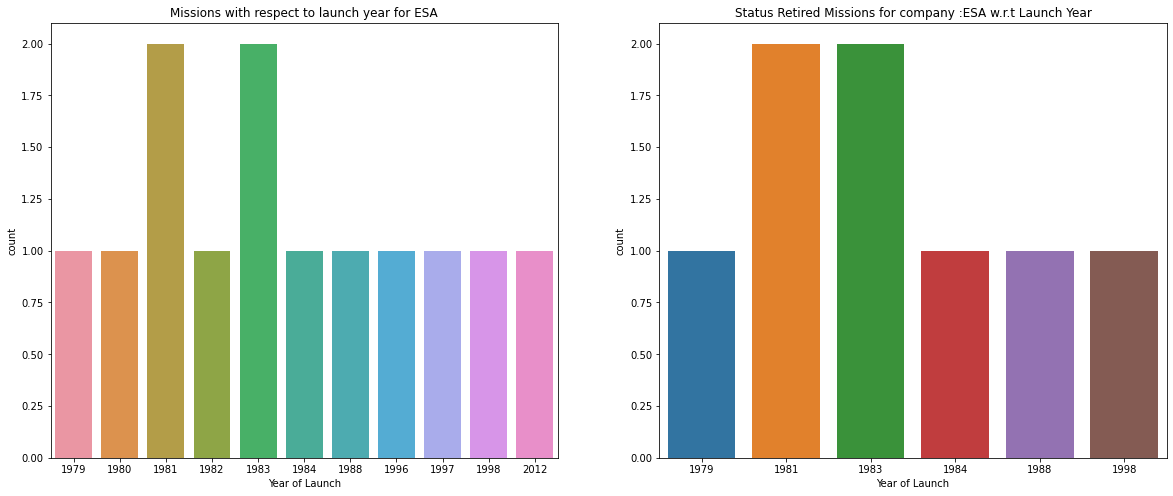

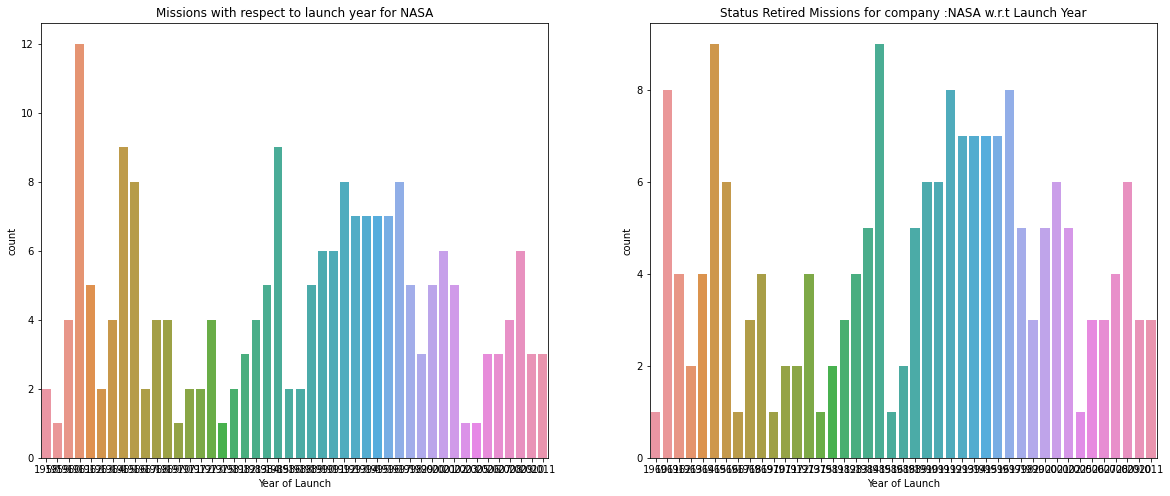

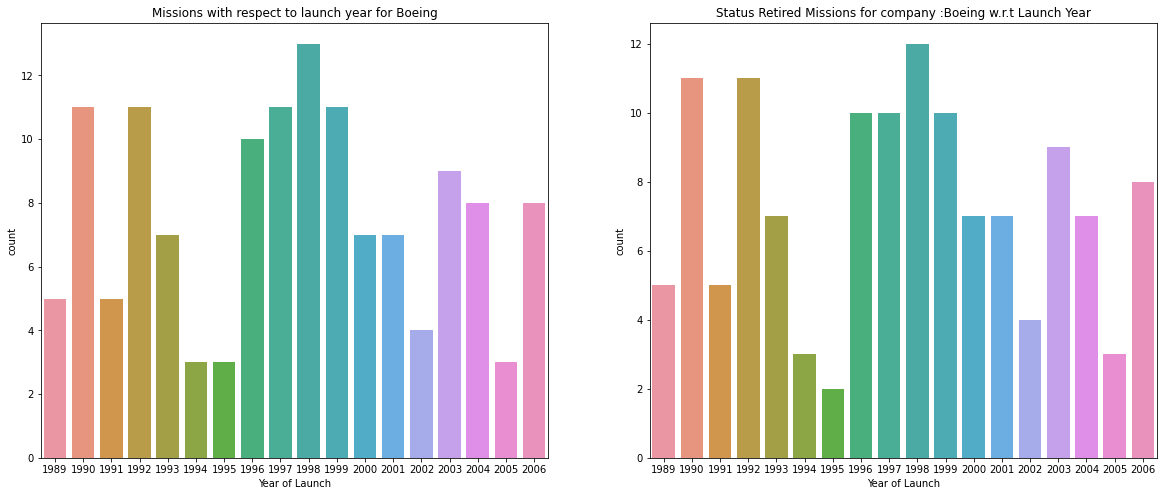

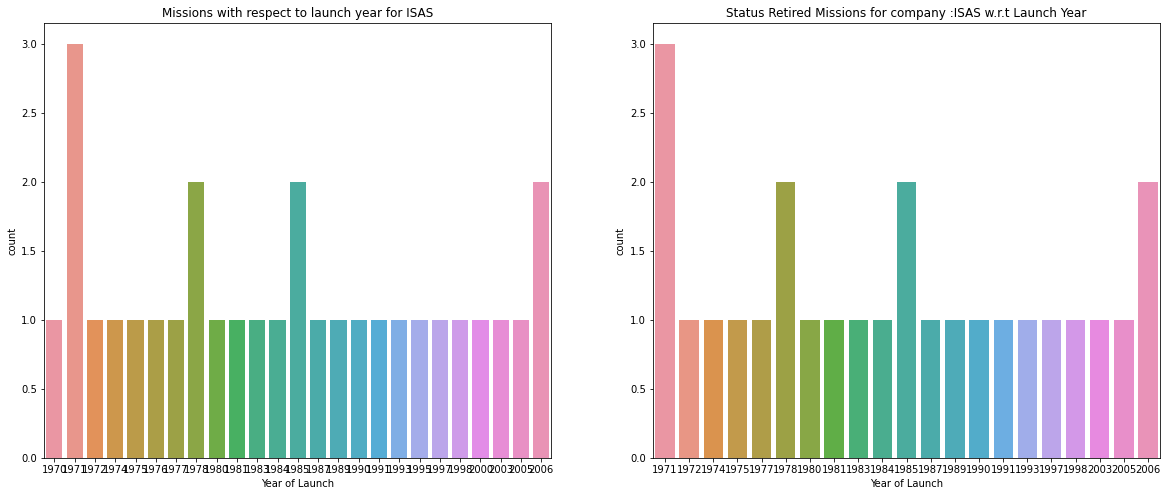

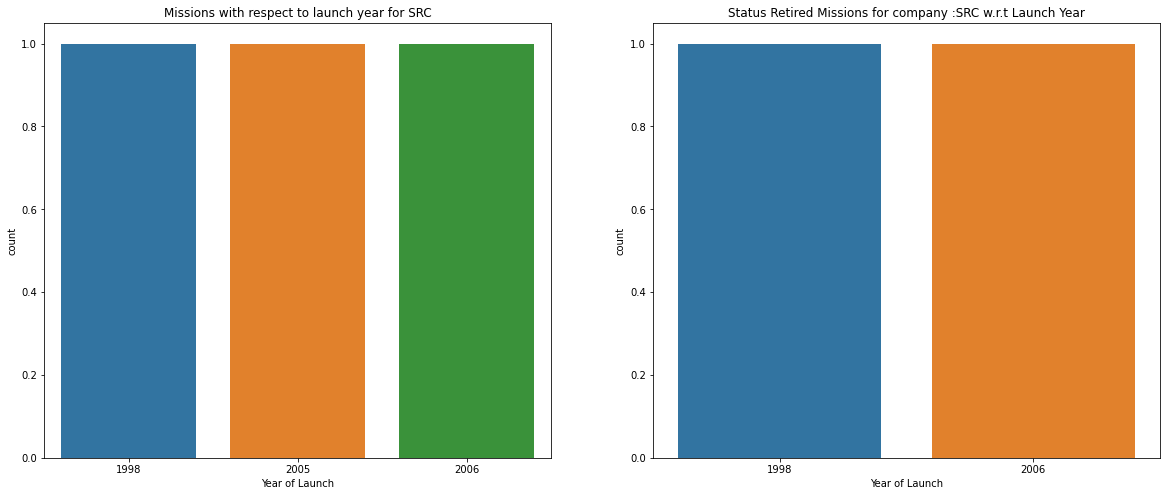

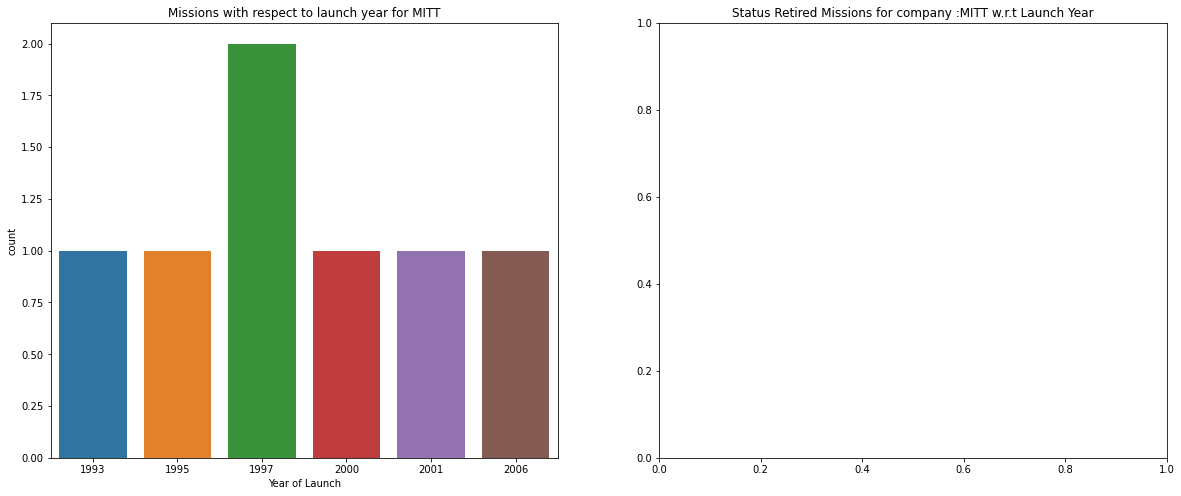

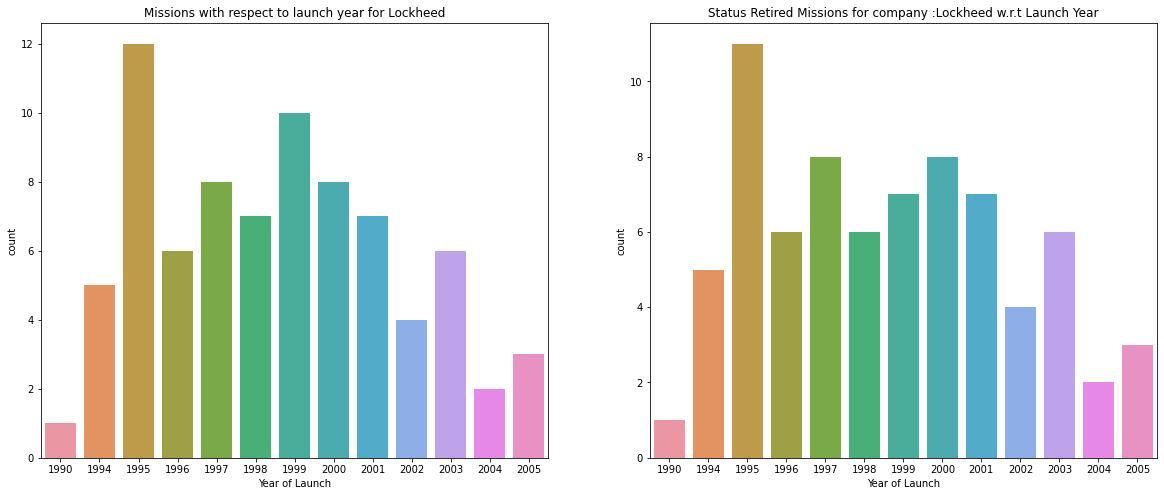

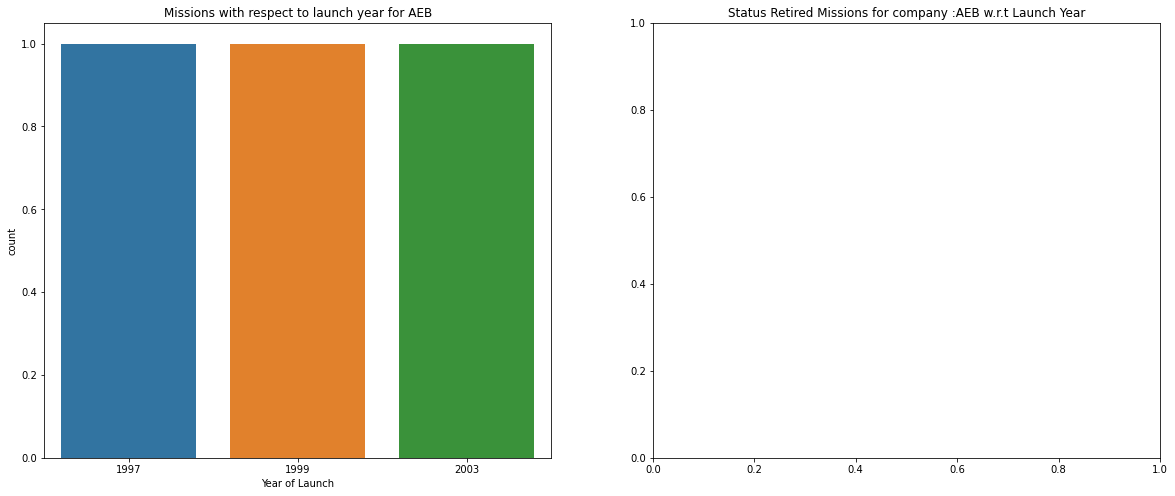

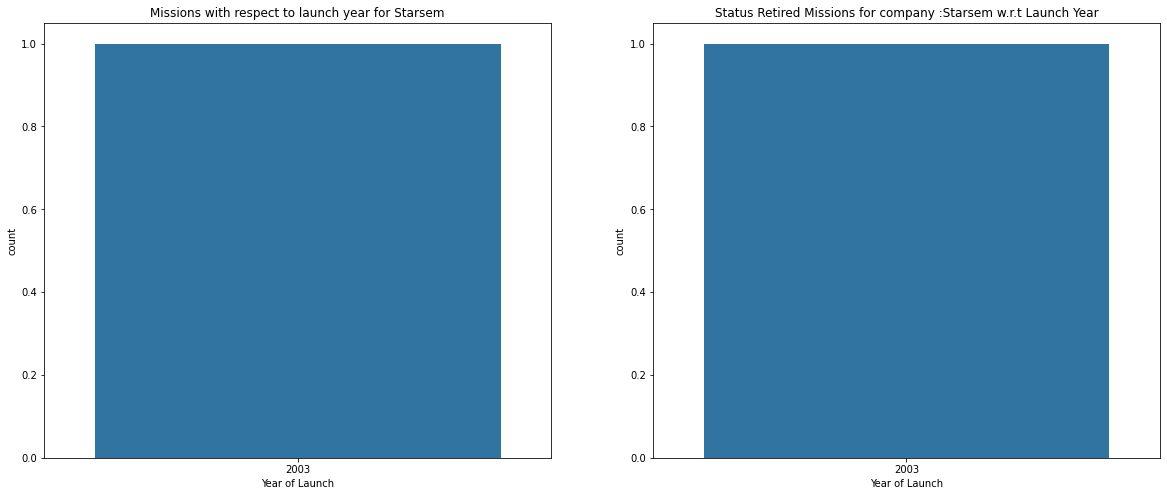

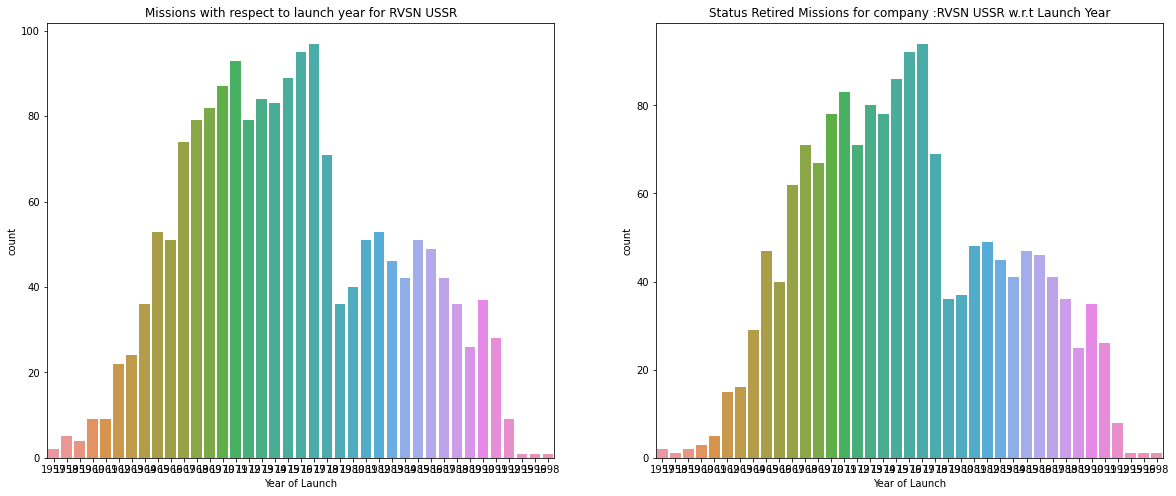

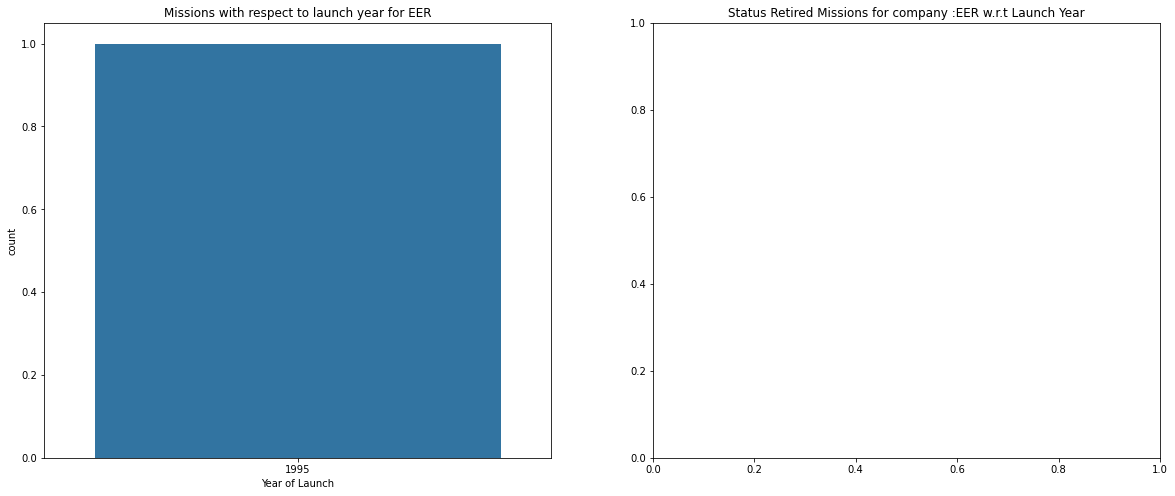

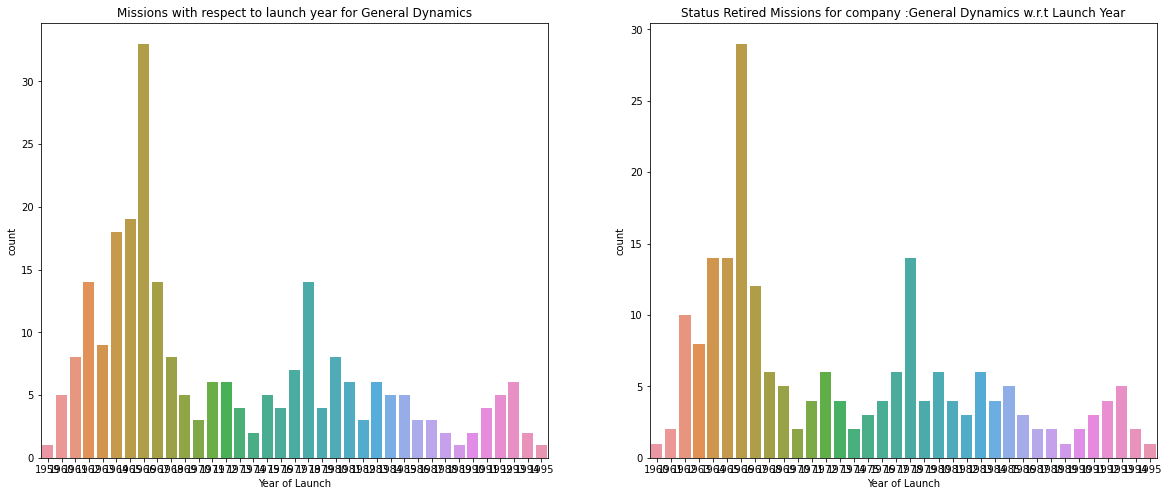

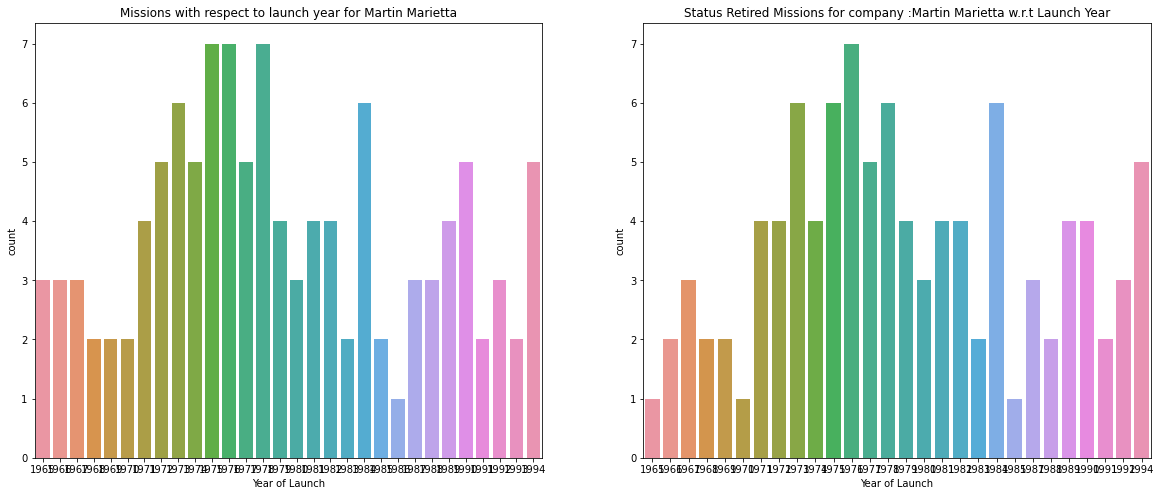

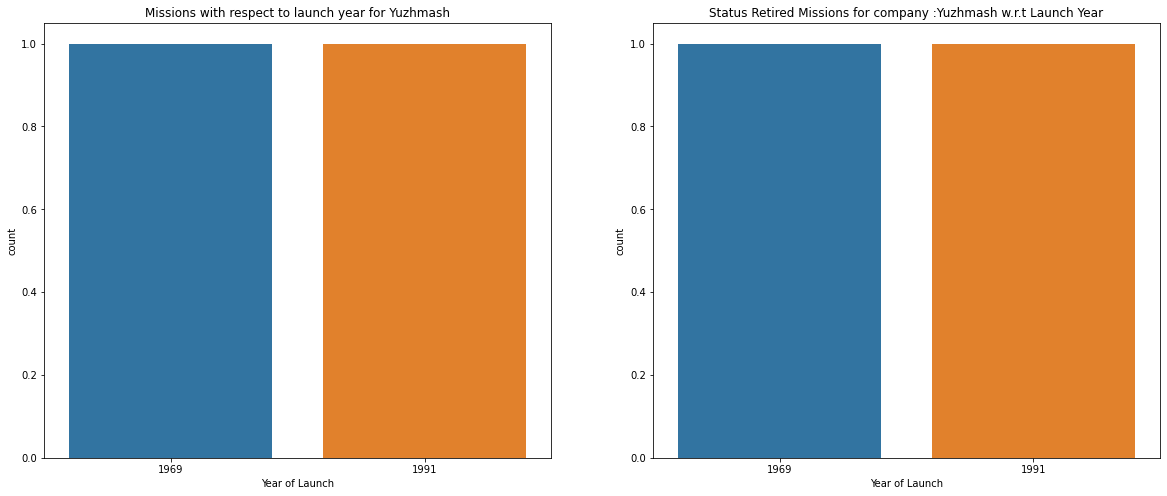

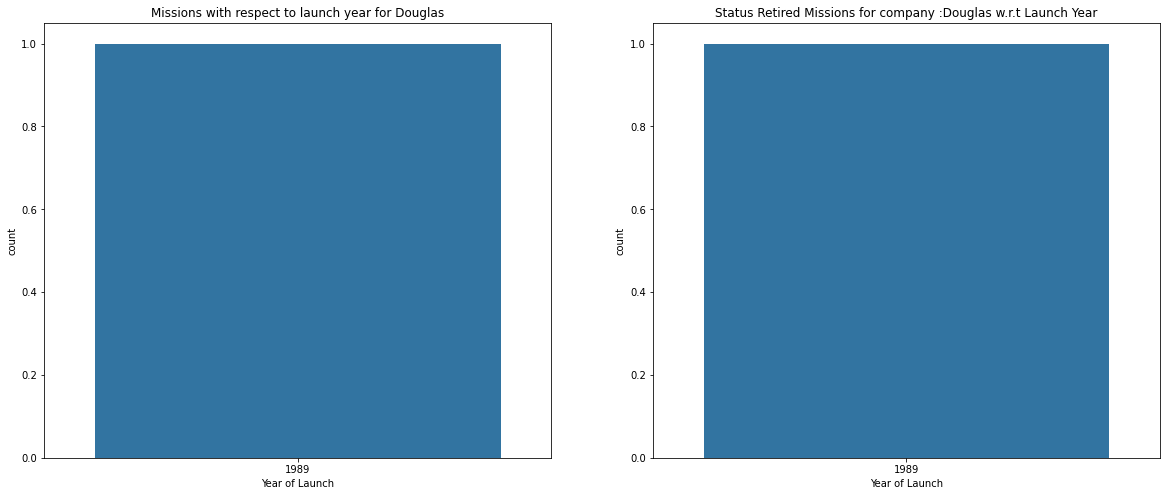

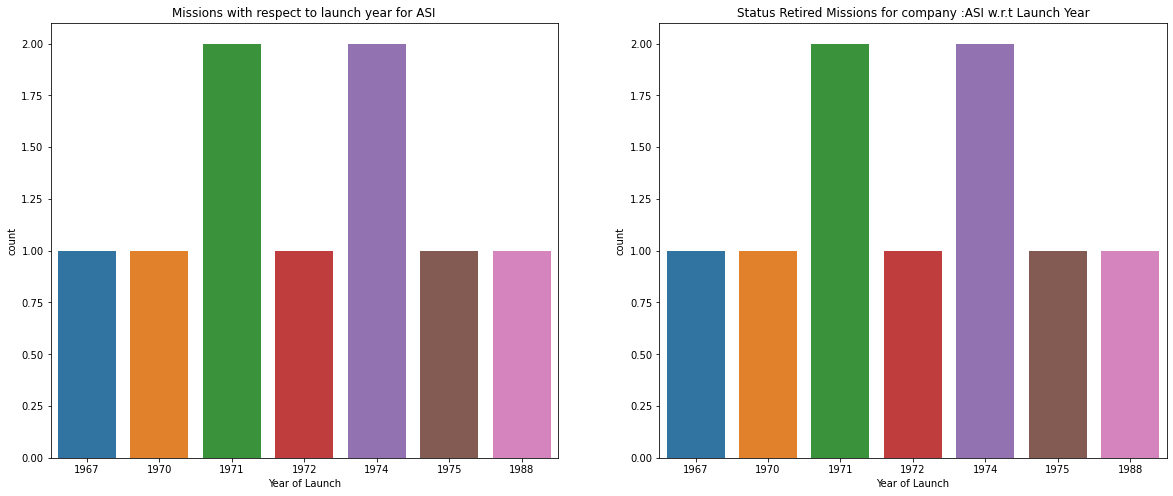

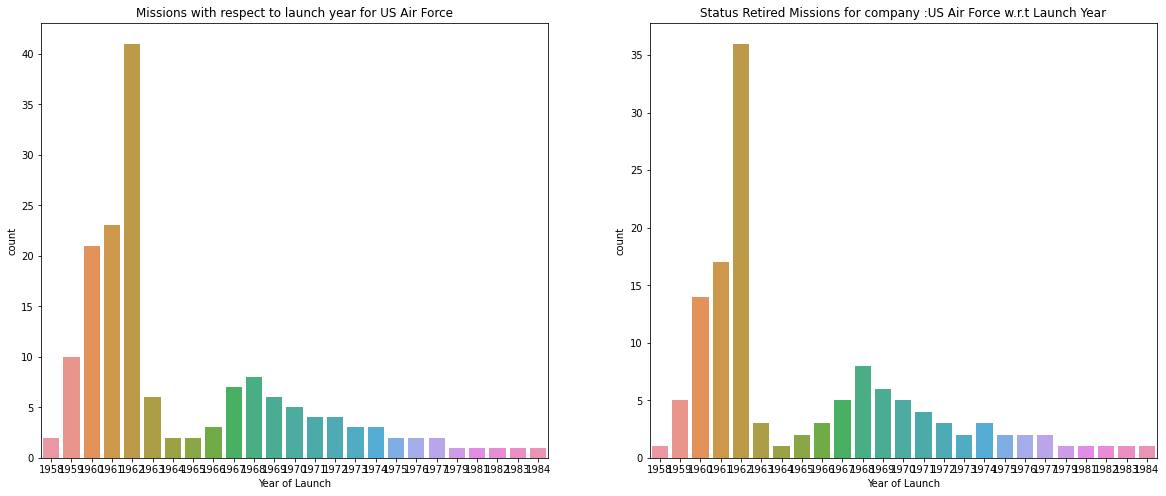

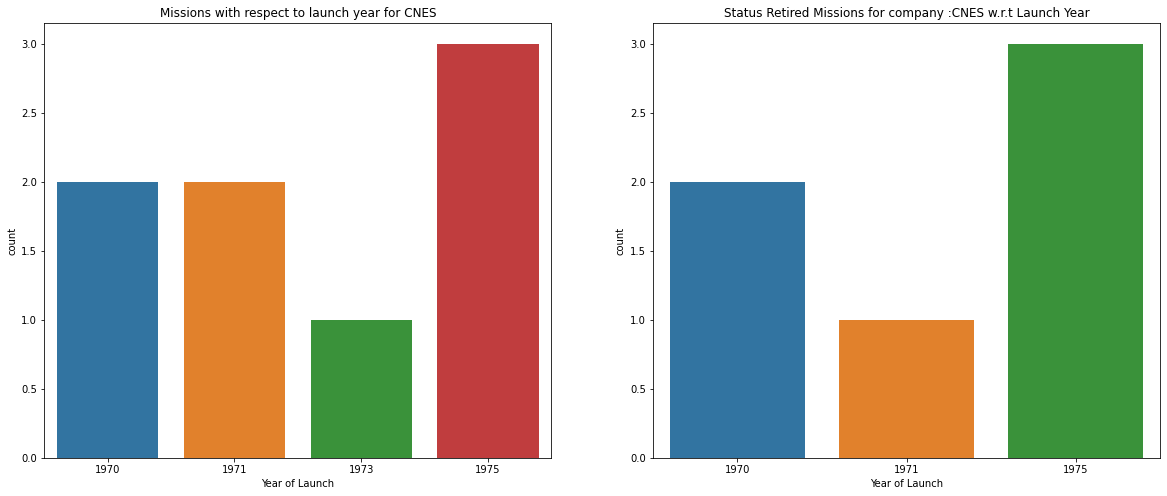

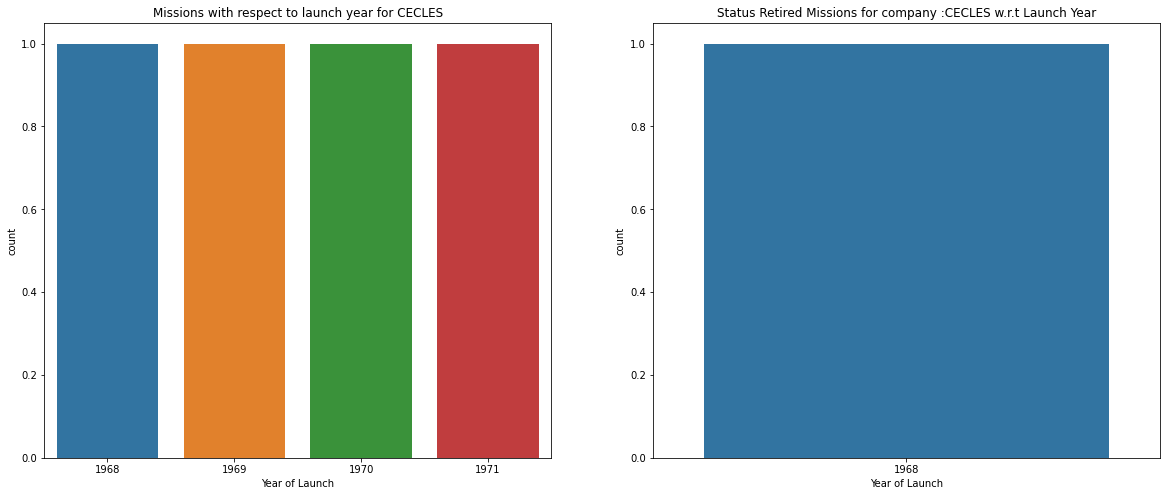

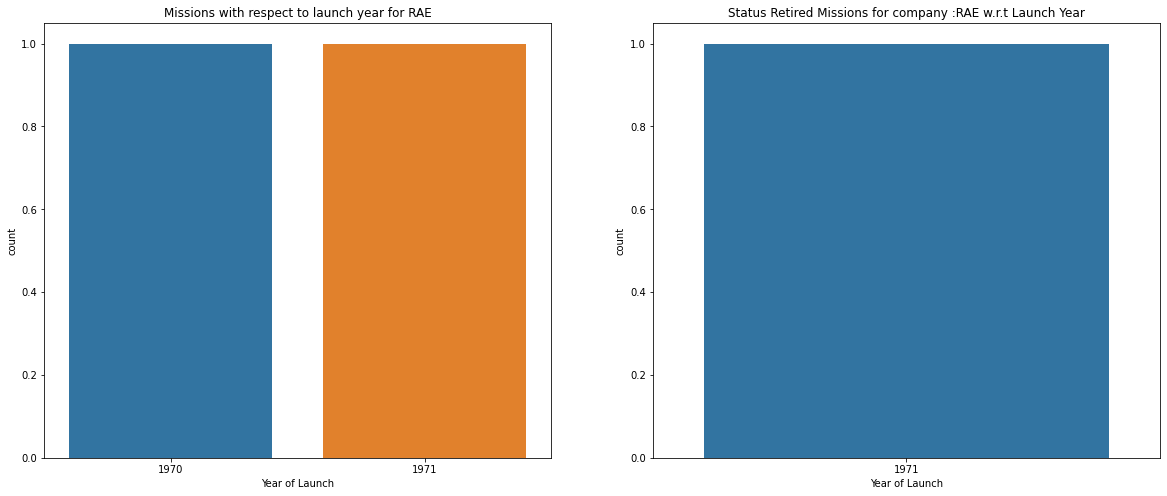

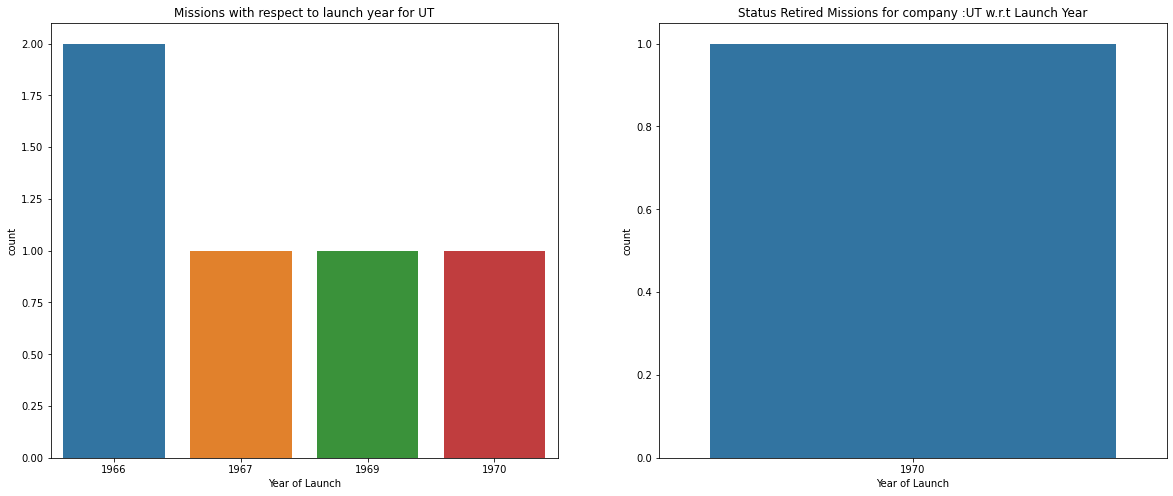

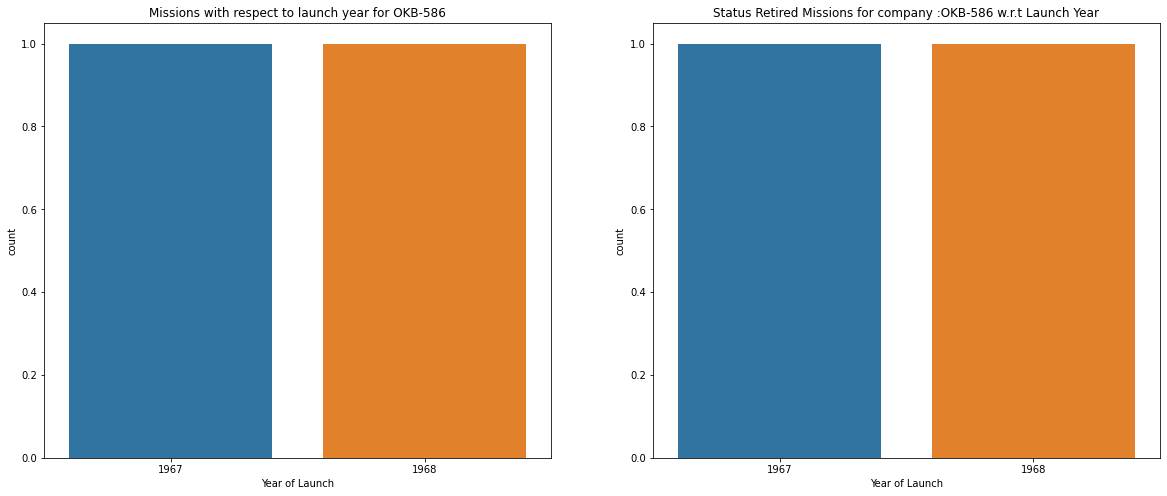

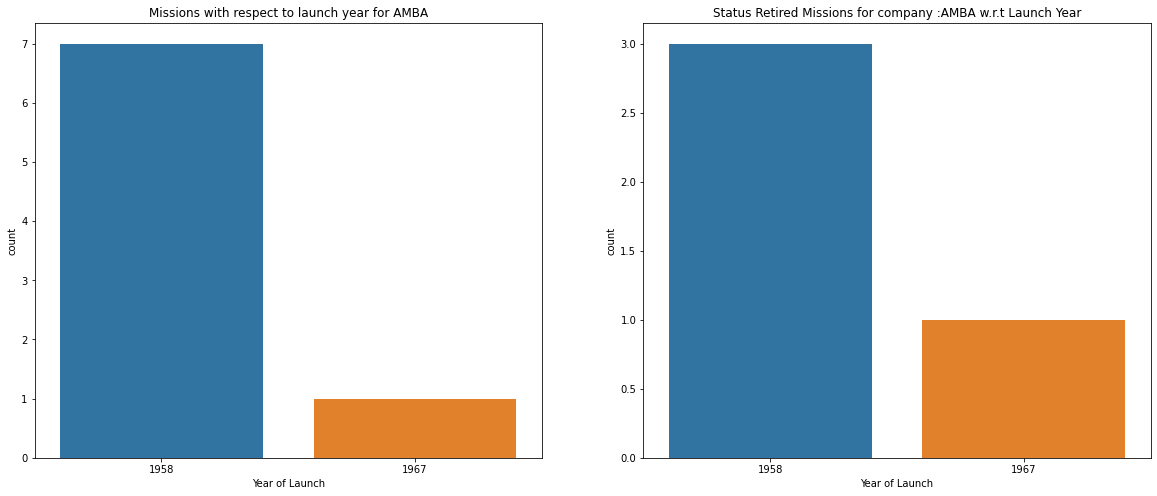

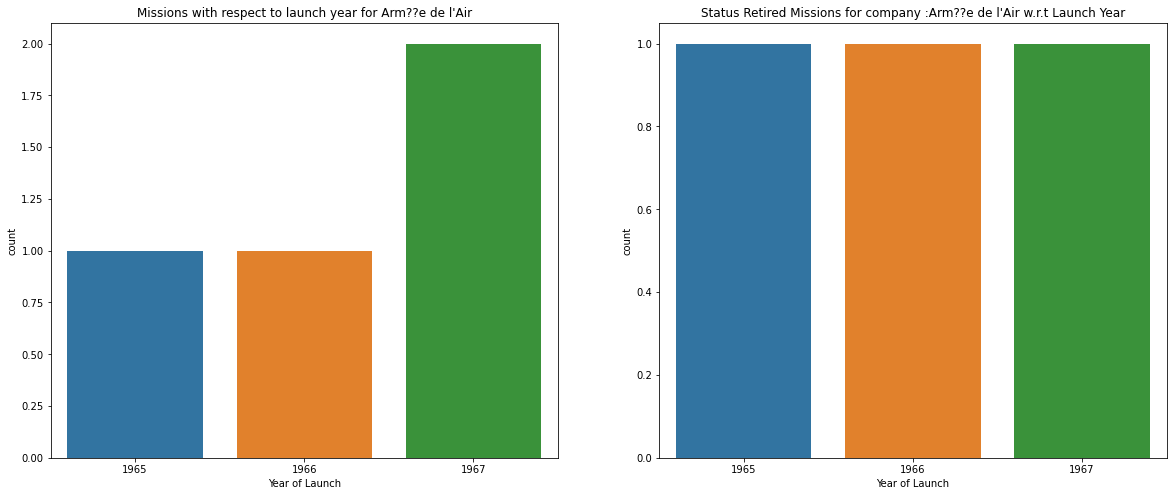

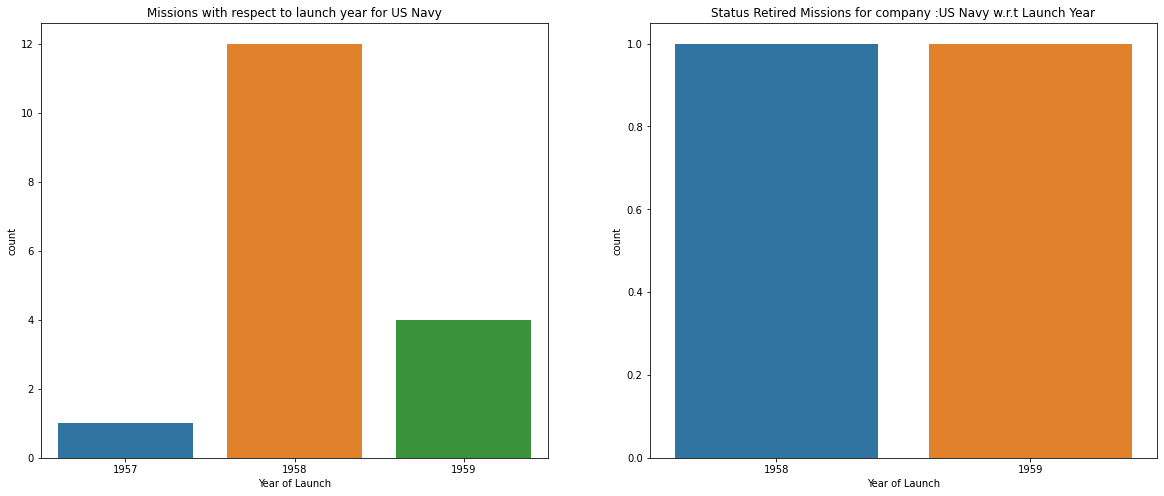

In [17]:
##### taking the plot with respect to year launch and total missions with respect to that year and the status retired missions and launch year
import warnings 
warnings.filterwarnings('ignore')
for company in company_list:
    tempdf1= space_df[space_df['Company Name']==company]
    fig,axs= plt.subplots(1,2,figsize=(20,8))
    axs[0].set_title(f'Missions with respect to launch year for {company}')
    sb.countplot(data=tempdf1,x='Year of Launch',ax=axs[0])
    tempdf2= tempdf1[(tempdf1['Rocket Status']=='StatusRetired') &(tempdf1['Mission Status']=='Success')]
    axs[1].set_title(f'Status Retired Missions for company :{company} w.r.t Launch Year')
    if tempdf2.shape[0]!=0:     
        
        sb.countplot(data=tempdf2,x='Year of Launch',ax=axs[1])
        
    
    
    

In [18]:
space_df.head()

,Company Name,Location of Launch,Date of Launch,Rocket Name,Rocket Status,Mission Status,Month of Launch,Year of Launch,Day Part of Launch,Country/Main Place of Launch
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,Success,Aug,2020,Morning,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,Success,Aug,2020,Night,China
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,Success,Aug,2020,Night,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,Success,Jul,2020,Night,Kazakhstan
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,Success,Jul,2020,Morning,USA


<AxesSubplot:title={'center':'Rocket usage'}, ylabel='Rocket Name'>

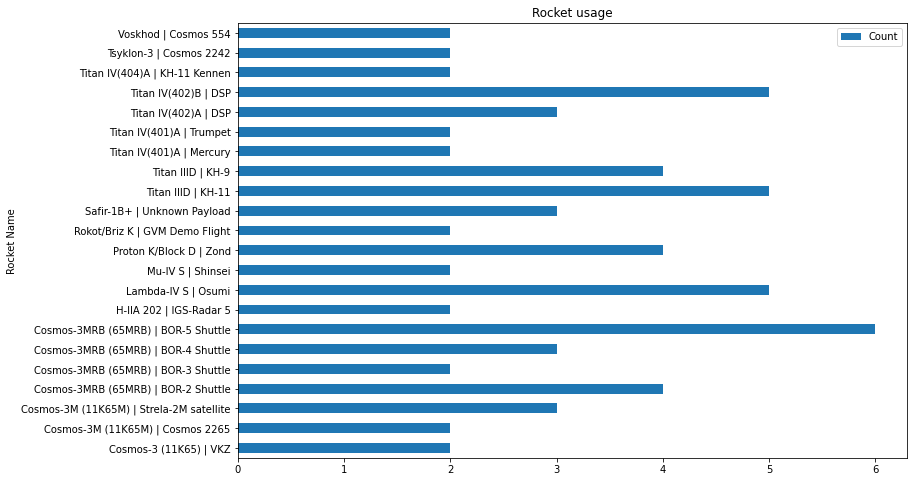

In [19]:
##### checking how many rockets are used again (more then one time)
rocketusage_df= pd.DataFrame(space_df.groupby('Rocket Name').size(),columns=['Count'])
### taking the count of rockets which has been used more than one time
rocketusage_df=rocketusage_df[rocketusage_df['Count']>1]
rocketusage_df.plot(figsize=(12,8),kind='barh',title='Rocket usage')

#### Observations:

1. Total 22 rockets has been re used at least 2 times.

2. The rocket which has been reused most is Cosmos-3MRB (65 MRB) | BOR-5 Shuttle (6 times)

3. Reusing the rockets helps to save the initial cost for missions , thus saving time as well

In [20]:
#### taking the count of rockets which has been used more than 2 and their corresponding company
rocketcompanyusage_df= pd.DataFrame(space_df.groupby(['Company Name','Rocket Name']).size(),columns=['Count'])
rocketcompanyusage_df= rocketcompanyusage_df[rocketcompanyusage_df['Count']>1]
rocketcompanyusage_df= rocketcompanyusage_df.reset_index()

In [21]:
rocketcompanyusage_df

,Company Name,Rocket Name,Count
0,ISA,Safir-1B+ | Unknown Payload,3
1,ISAS,Mu-IV S | Shinsei,2
2,Lockheed,Titan IV(402)B | DSP,5
3,MHI,H-IIA 202 | IGS-Radar 5,2
4,Martin Marietta,Titan IIID | KH-11,5
5,Martin Marietta,Titan IIID | KH-9,4
6,Martin Marietta,Titan IV(402)A | DSP,3
7,OKB-586,Cosmos-3 (11K65) | VKZ,2
8,RVSN USSR,Cosmos-3M (11K65M) | Strela-2M satellite,3
9,RVSN USSR,Cosmos-3MRB (65MRB) | BOR-2 Shuttle,4


<AxesSubplot:title={'center':'Count of companies which used rockets more than once'}, ylabel='Company Name'>

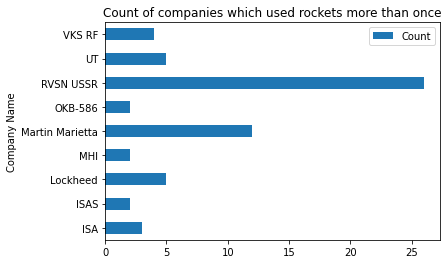

In [22]:
#### taking the count plot of companies/agency which re-uses the rockets 
df1= pd.DataFrame(rocketcompanyusage_df.groupby('Company Name').aggregate({'Count':'sum'}),columns=['Count'])
df1.plot(kind='barh',title='Count of companies which used rockets more than once')

##### Observations

1. RVSN USSR has used rockets more than once 


<AxesSubplot:title={'center':'Total Space missions with respect to countries'}, ylabel='Country/Main Place of Launch'>

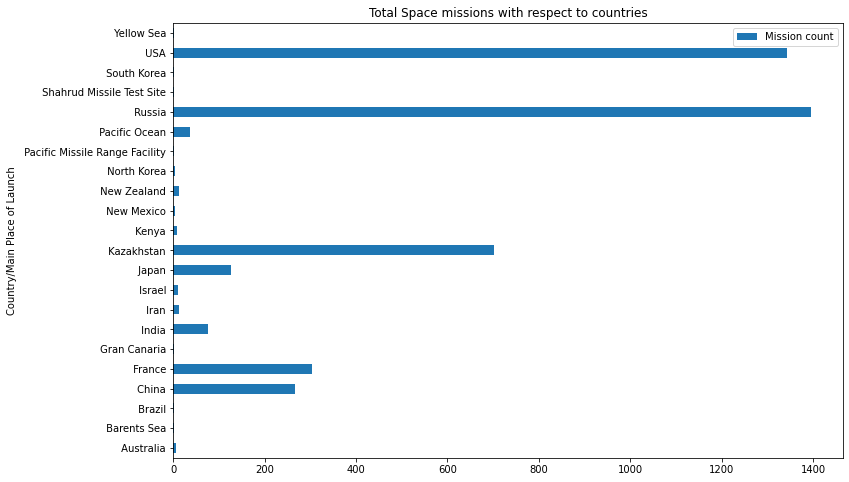

In [23]:
#### plotting the total space missions with respect to country

pd.DataFrame(space_df.groupby('Country/Main Place of Launch').size(),columns=['Mission count']).plot(kind='barh',title='Total Space missions with respect to countries',figsize=(12,8))


#### observations

1. USA & Russia had conducted more number of space missions 

2. This is followed by kazakhstan, Japan, India, France, China etc

<AxesSubplot:title={'center':'Total success Space missions with respect to countries'}, ylabel='Country/Main Place of Launch'>

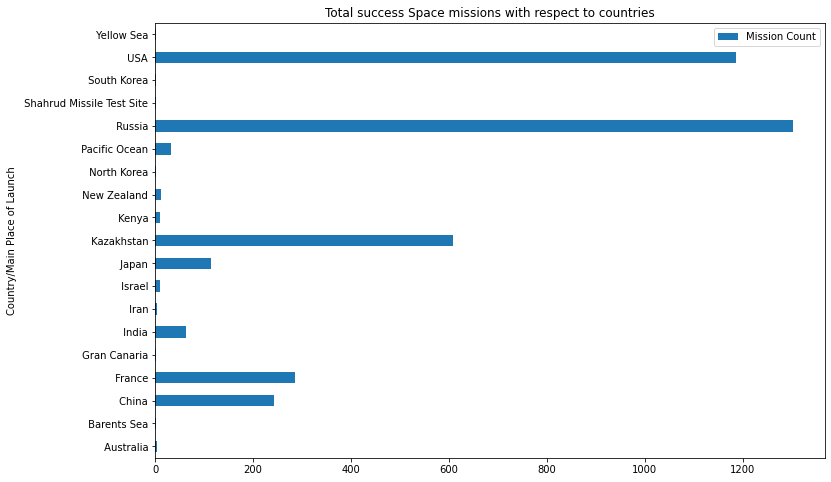

In [24]:
#### count of success mission with respect to each country
pd.DataFrame(space_df[space_df['Mission Status']=='Success'].groupby('Country/Main Place of Launch').size(),columns=['Mission Count']).plot(kind='barh',figsize=(12,8),title='Total success Space missions with respect to countries')

#### observations:

1. Russia and USA had conducted most successfull space missions 

2. This is followed by Kazahkstan, France, Japan, India, china

### ------------------------------------      Data Analysis for Space missions ----------------------------------